In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from tableone import TableOne
import math
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [5]:
from load_data import *
from figures import *

## Loading Data from NCDB

In [249]:
df = load_data_her2(filename="/mnt/data/NCDB/NCDBPUF_Breast.0.2020.csv", savefile="NCDB_Subset.csv", lower=True)
#Recharacterizing Group 2,3,4 IHC- cases as HER2-
df.loc[df.cat == 'E', 'cat'] = 'C'

#Dropping cases with unknown ISH results
df.drop(df[ df['cat'] == 'F'].index, inplace = True)
print("Excluding uncharacterizable cases: " + str(len(df.index)))

df.drop(df[ df['cat'] == 'H'].index, inplace = True)
print("Excluding uncharacterizable cases: " + str(len(df.index)))

df.drop(df[ df['cat'] == 'G'].index, inplace = True)
print("Excluding uncharacterizable cases: " + str(len(df.index)))

#Require dual probe ISH for HER2+ / HER2- cases with IHC 2+ or not performed
df = df[(~df.cat.isin(['AA','C'])) | ((df.her2.isin([0,1,3])) | ((~df.her2ratio.isna() | (df.her2copies < 4) | (df.her2copies >=6 )) & ((~df.her2copies.isna()))))]
df = df[(~df.cat.isin(['AA','C'])) | ((df.her2.isin([0,1,3])) | ((~df.her2ratio.isna()) & ((~df.her2copies.isna()))))]
print("Excluding uncharacterizable cases: " + str(len(df.index)))

#Require dual probe ISH for discordant ISH/IHC cases
df = df[(~df.cat.isin(['B'])) | ((~df.her2ratio.isna() | (df.her2copies < 4) | (df.her2copies >=6 )) & ((~df.her2copies.isna())))]
df = df[(~df.cat.isin(['B'])) | ((~df.her2ratio.isna()) & ((~df.her2copies.isna())))]
print("Excluding uncharacterizable cases: " + str(len(df.index)))

df = df[(~df.cat.isin(['D'])) | ((~df.her2ratio.isna() | (df.her2copies < 4) | (df.her2copies >=6 )) & ((~df.her2copies.isna())))]
df = df[(~df.cat.isin(['D'])) | ((~df.her2ratio.isna()) & ((~df.her2copies.isna())))]
print("Excluding uncharacterizable cases: " + str(len(df.index)))




Total Patients in NCDB: 3690015
Excluding diagnoses before 2013: 1962264
Excluding non-invasive cases: 1595553
Excluding Stage 0 cases: 1549077
Excluding uncharacterizable cases: 1417344
Excluding uncharacterizable cases: 1410433
Excluding uncharacterizable cases: 1408595
Excluding uncharacterizable cases: 1100067
Excluding uncharacterizable cases: 1096885
Excluding uncharacterizable cases: 1093829


## Demographic Analysis

### Baseline Demographics Tables for the Full Cohort, Neoadjuvant Cohort, and Survival Cohort

In [250]:
df_dem = df.copy()
baselineCharacteristics(df_dem, pval=True, lite = False, csv_filename='baseline_full_cohort.csv')

df_survival = df_dem[df_dem.immuno.isin([0,1]) & ~df_dem.last_contact.isna() & ~df_dem.alive.isna()]
baselineCharacteristics(df_survival, pval=True, lite = False, csv_filename='baseline_full_survival.csv')

df_dem = df_dem[df_dem.immuno.isin([0,1])]
df_dem = df_dem[(df_dem.neoadj_chemo == 1) & (~df_dem.pcr.isna())]
baselineCharacteristics(df_dem, pval=True, lite = False, csv_filename='baseline_full_cohort_neoadjuvant_known_io.csv')

Median Follow-up: 43.24
25% IQR: 27.33
75% IQR: 65.71
|                                     |                                       | Missing   | Overall        | A2           | A3           | A3-2         | A4           | AA            | B            | C             | D            | P-Value   |
|-------------------------------------|---------------------------------------|-----------|----------------|--------------|--------------|--------------|--------------|---------------|--------------|---------------|--------------|-----------|
| n                                   |                                       |           | 1093829        | 557          | 185          | 1850         | 288          | 148282        | 1131         | 940895        | 641          |           |
| Age, mean (SD)                      |                                       | 0         | 61.9 (13.2)    | 58.9 (14.1)  | 60.0 (14.7)  | 63.6 (12.7)  | 62.3 (13.4)  | 57.8 (13.6)   | 60.8 (13.8)  | 62.6 (13.0)   | 6

Median Follow-up: 43.33
25% IQR: 27.43
75% IQR: 65.81
|                                     |                                       | Missing   | Overall       | A2           | A3           | A3-2         | A4           | AA            | B            | C             | D            | P-Value   |
|-------------------------------------|---------------------------------------|-----------|---------------|--------------|--------------|--------------|--------------|---------------|--------------|---------------|--------------|-----------|
| n                                   |                                       |           | 922655        | 365          | 119          | 1223         | 189          | 122958        | 846          | 796539        | 416          |           |
| Age, mean (SD)                      |                                       | 0         | 61.8 (13.1)   | 58.7 (13.9)  | 60.0 (14.9)  | 63.6 (12.6)  | 62.6 (12.8)  | 57.4 (13.4)   | 60.1 (13.8)  | 62.5 (13.0)   | 61.6 

Median Follow-up: 43.93
25% IQR: 28.55
75% IQR: 64.95
|                                     |                                       | Missing   | Overall        | A2           | A3           | A3-2         | A4           | AA            | B            | C             | D            | P-Value   |
|-------------------------------------|---------------------------------------|-----------|----------------|--------------|--------------|--------------|--------------|---------------|--------------|---------------|--------------|-----------|
| n                                   |                                       |           | 146653         | 182          | 68           | 411          | 93           | 51723         | 290          | 93734         | 152          |           |
| Age, mean (SD)                      |                                       | 0         | 53.3 (12.4)    | 53.0 (12.9)  | 54.0 (13.0)  | 58.6 (12.2)  | 57.9 (13.5)  | 53.2 (12.4)   | 54.8 (12.5)  | 53.3 (12.4)   | 5

### Display Table 1 for Value Counts of ISH Groups (and percentages) for IHC 3+ and IHC 0-1+ cohorts

In [297]:
cond_list = []
df_test = df.copy()
df_test.loc[df_test.cat == 'A3-2', 'cat'] = 'A3'
df_test = df_test[(~df_test.cat.isin(['B','D'])) | ((~df_test.her2ratio.isna() | (df_test.her2copies < 4) | (df_test.her2copies >=6 )) & ((~df_test.her2copies.isna())))]
df_test = df_test[(~df_test.cat.isin(['AA','C'])) | ((df_test.her2.isin([0,1,3])) | ((~df_test.her2ratio.isna() | (df_test.her2copies < 4) | (df_test.her2copies >=6 )) & ((~df_test.her2copies.isna()))))]

df_test = df_test.drop(df_test[df_test.cat == 'F'].index)
condition = df_test.year >=2013
cond_list += [df_test.loc[condition & ( (~df_test.her2.isna()) & (~df_test.her2ratio.isna()) & (~df_test.her2copies.isna())), 'asco_group'].value_counts()]
cond_list += [df_test.loc[condition & ( (df_test.her2 == 3) & (~df_test.her2ratio.isna()) & (~df_test.her2copies.isna())), 'asco_group'].value_counts()]
cond_list += [df_test.loc[condition & ( (df_test.her2 <= 1) & (~df_test.her2ratio.isna()) & (~df_test.her2copies.isna())), 'asco_group'].value_counts()]
df_m = pd.concat(cond_list, axis = 1)
df_m.columns = ['HER2 IHC + Dual Probe ISH', 'HER2 IHC 3 + Dual Probe ISH', 'HER2 IHC 0-1 + Dual Probe ISH']

df_m = df_m.fillna(value = 0)
for c in df_m.columns:
    df_m[c] = df_m[c].apply(lambda x: "," + str(x) + " (" + str(round(100 * x/df_m[c].sum(), 2)) + ")")
df_m = df_m.reindex([1,2,3,4,5])
print(df_m)




  HER2 IHC + Dual Probe ISH HER2 IHC 3 + Dual Probe ISH  \
1             ,14673 (11.3)               ,5137 (75.46)   
2               ,5970 (4.6)                 ,557 (8.18)   
3              ,2453 (1.89)                 ,185 (2.72)   
4              ,9977 (7.69)                 ,288 (4.23)   
5            ,96724 (74.52)                 ,641 (9.42)   

  HER2 IHC 0-1 + Dual Probe ISH  
1                  ,1131 (2.37)  
2                  ,1402 (2.93)  
3                   ,418 (0.87)  
4                  ,2330 (4.87)  
5                ,42536 (88.96)  


## Neoadjuvant Cohort Analysis
### Figure 2 Plot and Data

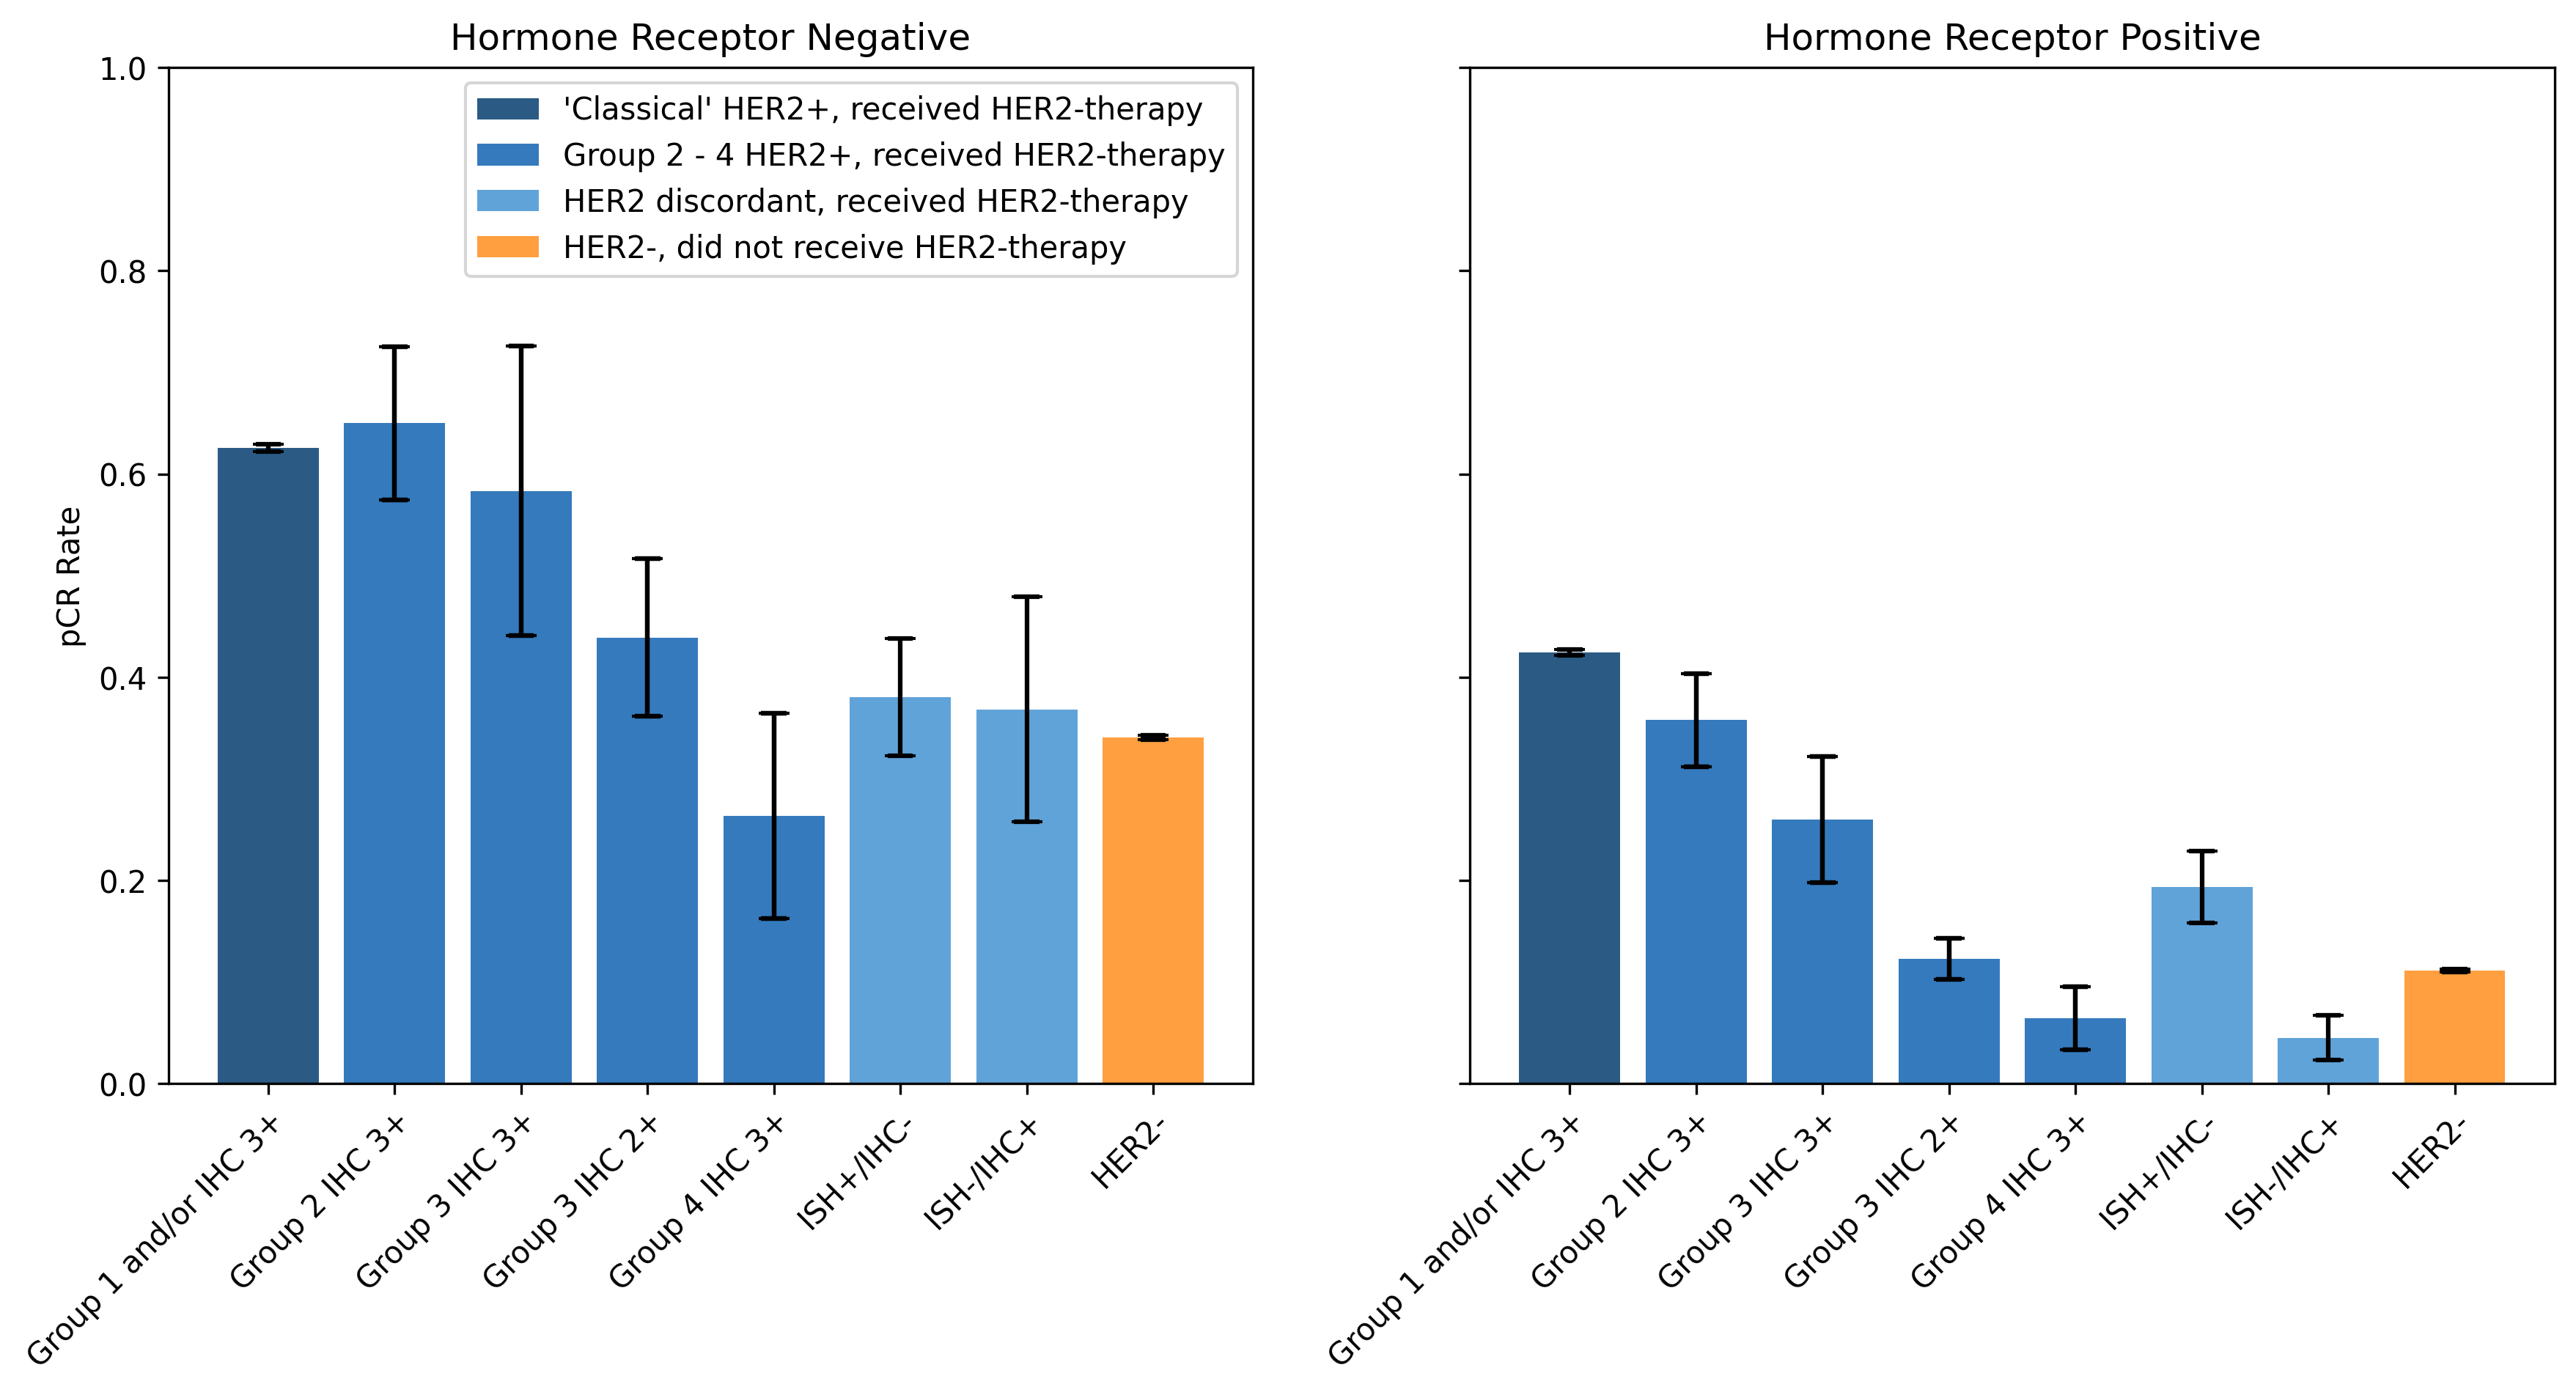

In [331]:
def bar_plot_stats(cats, lite = False, groups = True):
    """Calculate pCR rates and standard errors (for plotting) across patient subgroups
    Parameters
    ----------
    cats - dataframe to be used for analysis
    lite - if True, use 4 category classification (HER+/HER2-, and discordant cases; otherwise use 8 category classification that also includes Group 2, Group 3 (IHC 3 vs 2+), and Group 4 cases
    groups - if True, use the 'catnew' column instead of the previously defined classifications to define groups for calculating pCR rates
    
    Returns
    -------
    rates, standard_errors, sizes: tuple of dictionaries including the pCR rates, standard errors for pCR rates, and sample sizes for each category
    """
    
    rates = {}
    if groups:
        col = 'catnew'
        cat_values = cats[col].unique()
        key_mapping = {}
        for c in cat_values:
            key_mapping[c] = c
    else:
        if lite:
            cat_values = ['p','n','pn','np']
            key_mapping = {
                'p':'HER2+',
                'n':'HER2-',
                'pn':'IHC-/ISH+',
                'np':'IHC+/ISH-'
            }
            col = 'cat4'
        else:
            cat_values = ['AA','A2','A3','A3-2','A4','B','C','D']
            key_mapping = {
            'AA': 'Group 1 and/or IHC 3+',
            'A2': 'Group 2 IHC 3+',
            'A3': 'Group 3 IHC 3+',
            'A3-2': 'Group 3 IHC 2+',
            'A4': 'Group 4 IHC 3+',
            'B': 'ISH+/IHC-',
            'C': 'HER2-',
            'D': 'ISH-/IHC+',
            }
            col = 'cat'

    for cat_value in cat_values:
        subset = cats[cats[col] == cat_value]
        if len(subset) == 0:
            rate = 0
        else:
            rate = sum(subset['pcr'] == 1) / len(subset)
        rates[cat_value] = rate

    standard_errors = {}
    sizes = {}
    for cat_value in cat_values:
        subset = cats[cats[col] == cat_value]
        n = len(subset)
        if n == 0:
            standard_error = 0
        else:
            p = rates[cat_value]
            standard_error = math.sqrt((p * (1 - p)) / n)
        standard_errors[cat_value] = standard_error
        sizes[cat_value] = n
    rates = {key_mapping[key]: value for key, value in rates.items()}
    standard_errors = {key_mapping[key]: value for key, value in standard_errors.items()}
    sizes = {key_mapping[key]: value for key, value in sizes.items()}
    return rates, standard_errors, sizes


def plot_bars_fig2(rates, standard_errors, order, diagonal, ax):
    """Generates bar plot using predefined color groupings for HER2+ subgroups
    Parameters
    ----------
    rates - pCR rates from bar_plot_stats
    standard_errors - SE from bar_plot_stats
    order - order to plot bars (listed as name of keys from rates/standard errors)
    diagonal - If true, plot labels at an angle for the x axis
    ax - provided axis to plot the graph
    
    Returns
    -------
    rates, standard_errors, sizes: tuple of dictionaries including the pCR rates, standard errors for pCR rates, and sample sizes for each category
    """
    if ax is None:
        fig, ax = plt.subplots()

    ordered_rates = {key: rates[key] for key in order}
    ordered_errors = {key: standard_errors[key] for key in order}
    group1index = [0,1,2,3,4]
    group2index = [1,2,3,4]
    group3index = [5,6]
    group4index = [7]
    plot_range = [0,1,2,3,4,5,6,7]
    bars1 = ax.bar([plot_range[x] for x in group1index], [list(ordered_rates.values())[x] for x in group1index],  color='#2B5B84', label = '\'Classical\' HER2+, received HER2-therapy')
    bars2 = ax.bar([plot_range[x] for x in group2index], [list(ordered_rates.values())[x] for x in group2index],  color = '#357abD', label = 'Group 2 - 4 HER2+, received HER2-therapy')
    bars3 = ax.bar([plot_range[x] for x in group3index], [list(ordered_rates.values())[x] for x in group3index],  color = '#60a3d9', label = 'HER2 discordant, received HER2-therapy')
    bars4 = ax.bar([plot_range[x] for x in group4index], [list(ordered_rates.values())[x] for x in group4index],  color = '#ff9f40', label = 'HER2-, did not receive HER2-therapy')
    
    
    #bars = ax.bar([0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18], ordered_rates.values(), color=ordered_colors)
    
    errors = [list(ordered_errors.values())[x] for x in group1index]
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2.0
        error = errors[i]
        
        ax.errorbar(x, height, yerr=error, color='black', capsize=5)
        
        ax.hlines(y=height + error, xmin=x-0.1, xmax=x+0.1, color='black')
        ax.hlines(y=height - error, xmin=x-0.1, xmax=x+0.1, color='black')

    errors = [list(ordered_errors.values())[x] for x in group2index]
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2.0
        error = errors[i]
        
        ax.errorbar(x, height, yerr=error, color='black', capsize=5)
        
        ax.hlines(y=height + error, xmin=x-0.1, xmax=x+0.1, color='black')
        ax.hlines(y=height - error, xmin=x-0.1, xmax=x+0.1, color='black')

    errors = [list(ordered_errors.values())[x] for x in group3index]
    for i, bar in enumerate(bars3):
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2.0
        error = errors[i]
        
        ax.errorbar(x, height, yerr=error, color='black', capsize=5)
        
        ax.hlines(y=height + error, xmin=x-0.1, xmax=x+0.1, color='black')
        ax.hlines(y=height - error, xmin=x-0.1, xmax=x+0.1, color='black')
    errors = [list(ordered_errors.values())[x] for x in group4index]
    for i, bar in enumerate(bars4):
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2.0
        error = errors[i]
        
        ax.errorbar(x, height, yerr=error, color='black', capsize=5)
        
        ax.hlines(y=height + error, xmin=x-0.1, xmax=x+0.1, color='black')
        ax.hlines(y=height - error, xmin=x-0.1, xmax=x+0.1, color='black')
    ax.set_ylim(0, 1.0)
    if diagonal:
        ax.set_xticks(plot_range)
        ax.set_xticklabels(ordered_rates.keys(), rotation=45, ha="right", rotation_mode="anchor")

    if ax is None:
        plt.show()

        
neoadj = df.copy()
neoadj = neoadj[neoadj.immuno.isin([0,1])]
neoadj = neoadj[(~neoadj.pcr.isna()) & (neoadj.neoadj_chemo == 1) & (((neoadj.neoadj_immuno == 1) & (neoadj.cat != 'C')) | ((neoadj.neoadj_immuno != 1) & (neoadj.cat == 'C'))) ]

neoadj_tnbc = neoadj[(neoadj['er']=='-') &(neoadj['pr']=='-')]
neoadj_hr = neoadj[(neoadj['er']=='+') |(neoadj['pr']=='+')]

rates, standard_errors, counts = bar_plot_stats(neoadj_hr, groups = False)
order = ['Group 1 and/or IHC 3+','Group 2 IHC 3+','Group 3 IHC 3+', 'Group 3 IHC 2+', 'Group 4 IHC 3+','ISH+/IHC-','ISH-/IHC+','HER2-']
fig, axs = plt.subplots(1, 2, dpi = 300, sharey = True, figsize = (14, 6))
axs[1].set_title("Hormone Receptor Positive")

axs[0].set_ylabel("pCR Rate")
axs[0].set_title("Hormone Receptor Negative")
plot_bars_fig2(rates, standard_errors,order,diagonal = True, ax = axs[1])
rates, standard_errors, counts = bar_plot_stats(neoadj_tnbc, groups = False)
plot_bars_fig2(rates, standard_errors,order,diagonal = True, ax = axs[0])
axs[0].legend()

plt.show()

### Supplemental Figure 2 Plot and Data

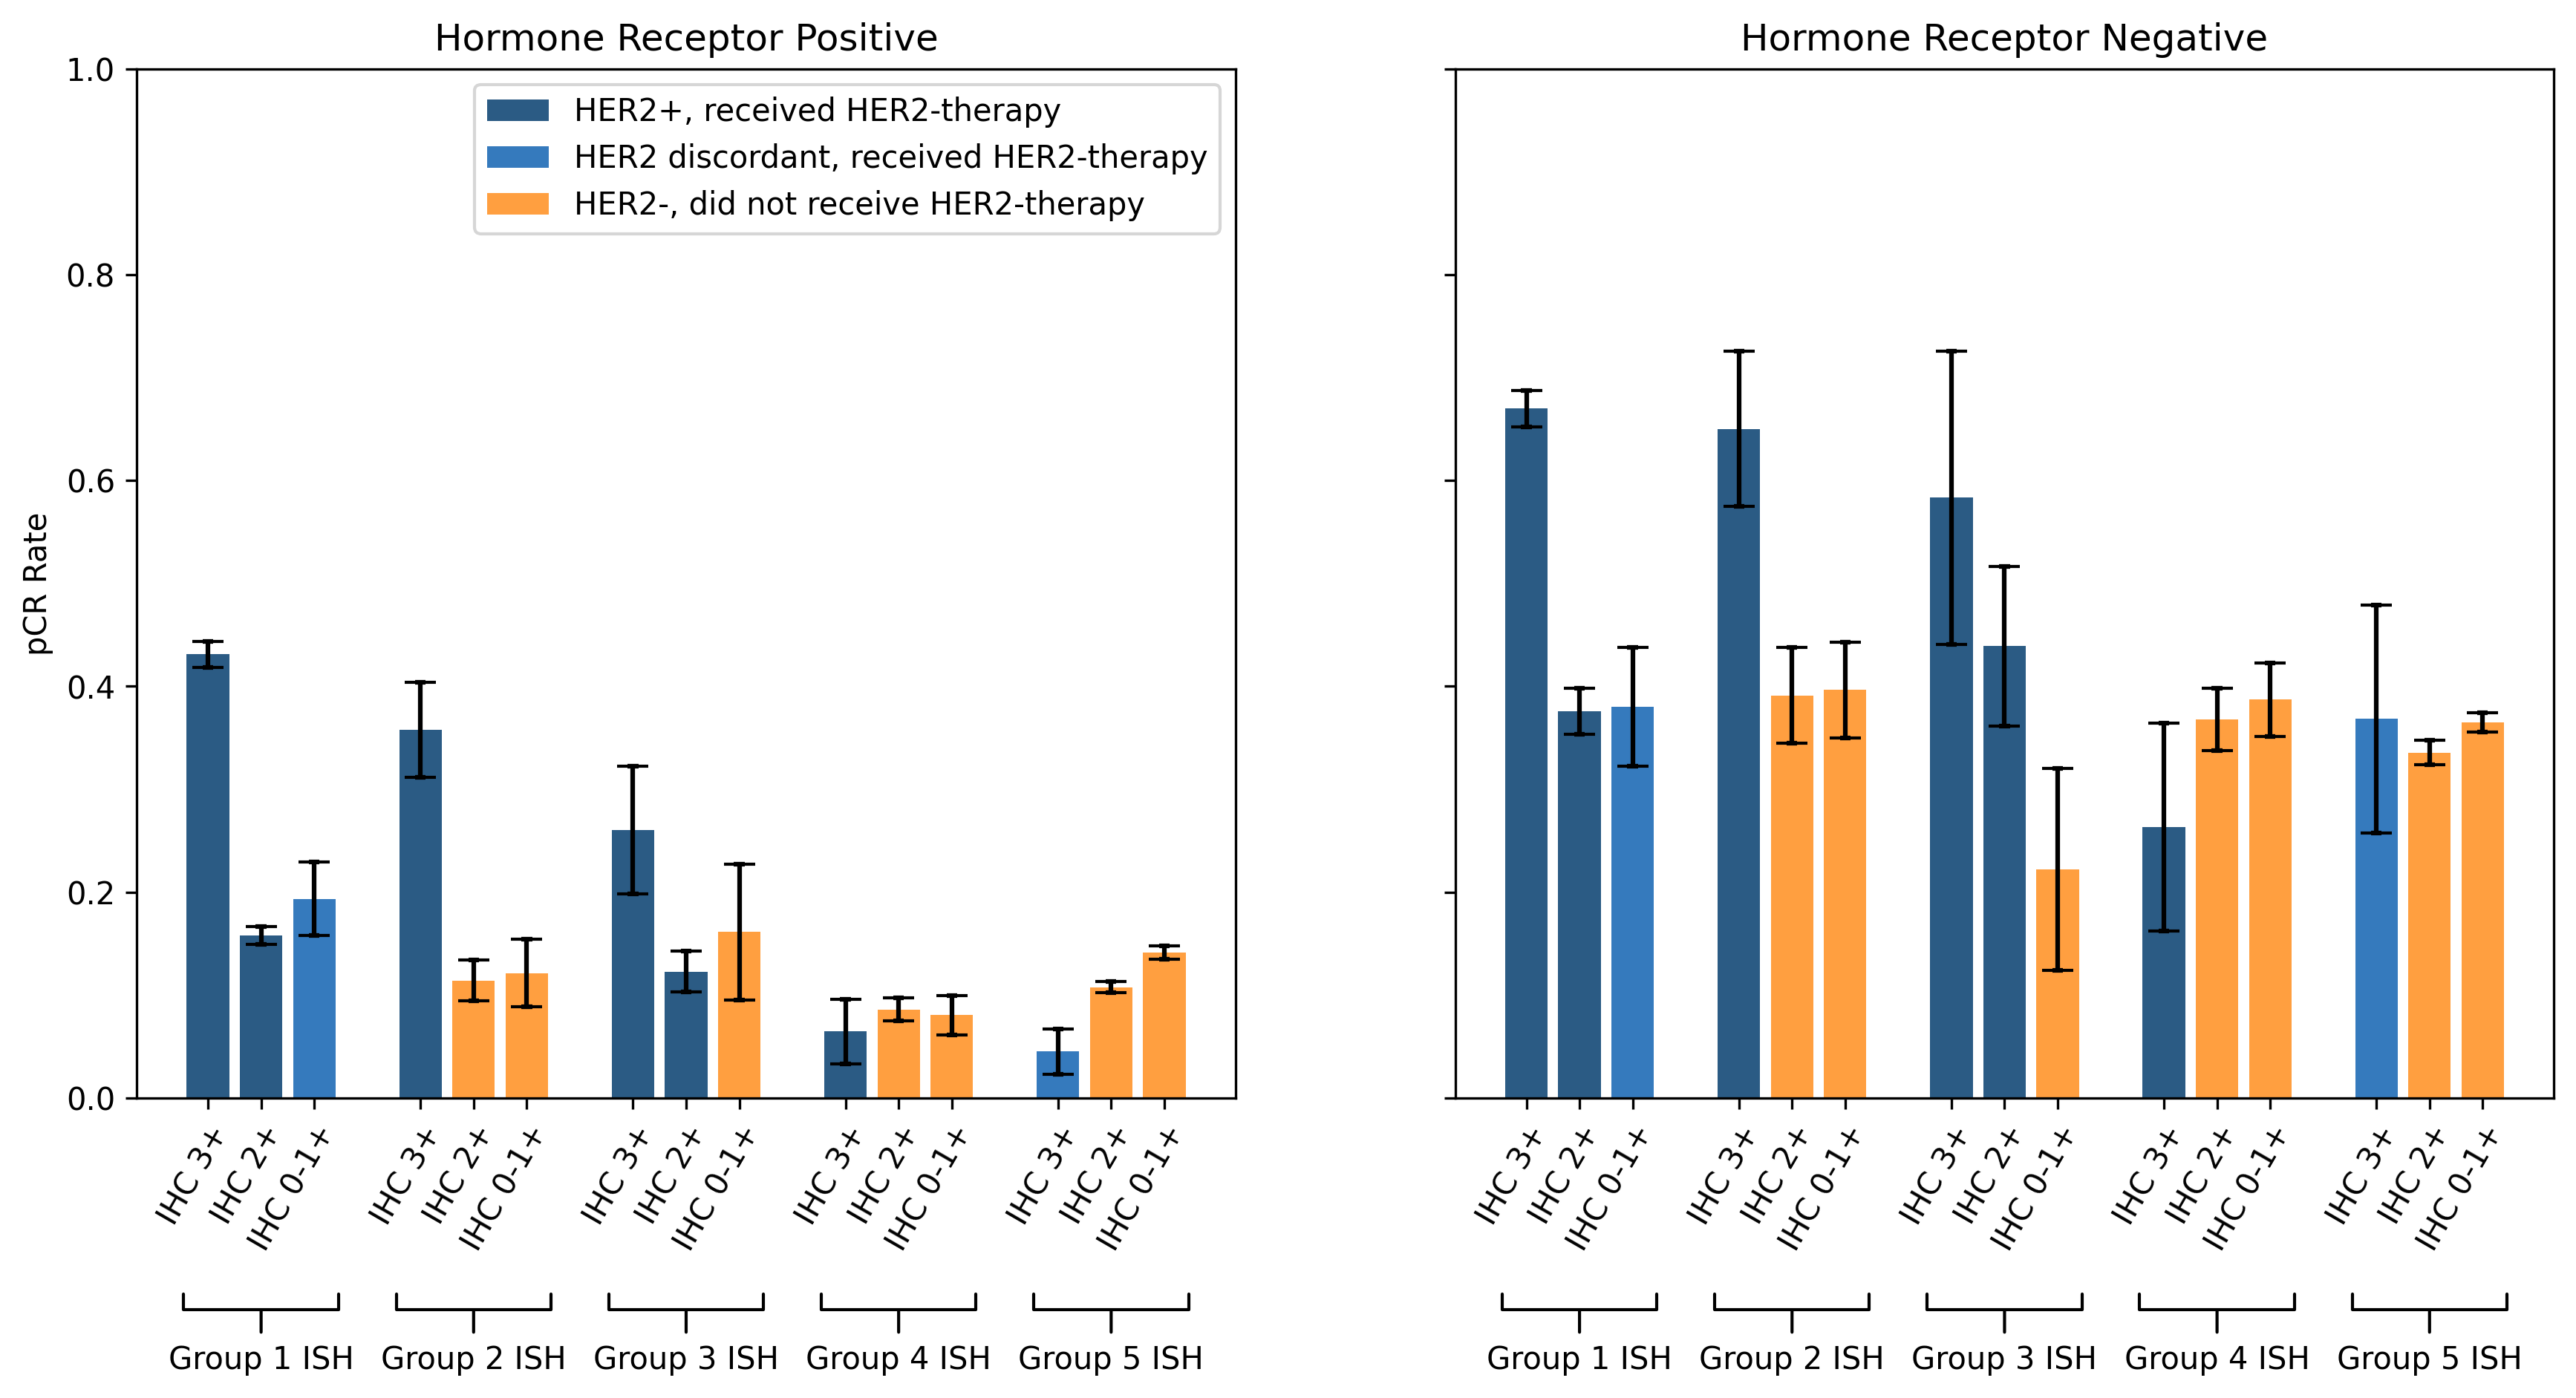

In [332]:
def plot_bars_supp2(rates, standard_errors, order, diagonal, ax, names):
    """Generates bar plot using predefined color groupings for cases with both ISH and IHC
    Parameters
    ----------
    rates - pCR rates from bar_plot_stats
    standard_errors - SE from bar_plot_stats
    order - order to plot bars (listed as name of keys from rates/standard errors)
    diagonal - If true, plot labels at an angle for the x axis
    ax - provided axis to plot the graph
    
    Returns
    -------
    rates, standard_errors, sizes: tuple of dictionaries including the pCR rates, standard errors for pCR rates, and sample sizes for each category
    """
    if ax is None:
        fig, ax = plt.subplots()

    ordered_rates = {key: rates[key] for key in order}
    ordered_errors = {key: standard_errors[key] for key in order}
    group1 = [0,1,4,8,9,12]
    plot_range = [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18]
    group1index = [0,1,3,6,7,9]
    group2index = [2,12]
    group3index = [4,5,8,10,11,13,14]
    group2 = [2,16]
    group3 = [5,6,10,13,14,17,18]
    bars1 = ax.bar([plot_range[x] for x in group1index], [list(ordered_rates.values())[x] for x in group1index], color='#2B5B84', label = 'HER2+, received HER2-therapy')
    bars2 = ax.bar([plot_range[x] for x in group2index], [list(ordered_rates.values())[x] for x in group2index],  color = '#357abD', label = 'HER2 discordant, received HER2-therapy')
    bars3 = ax.bar([plot_range[x] for x in group3index], [list(ordered_rates.values())[x] for x in group3index],  color = '#ff9f40', label = 'HER2-, did not receive HER2-therapy')
    
    #bars = ax.bar([0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18], ordered_rates.values(), color=ordered_colors)
    
    errors = [list(ordered_errors.values())[x] for x in group1index]
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2.0
        error = errors[i]
        
        ax.errorbar(x, height, yerr=error, color='black', capsize=5)
        
        ax.hlines(y=height + error, xmin=x-0.1, xmax=x+0.1, color='black')
        ax.hlines(y=height - error, xmin=x-0.1, xmax=x+0.1, color='black')

    errors = [list(ordered_errors.values())[x] for x in group2index]
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2.0
        error = errors[i]
        
        ax.errorbar(x, height, yerr=error, color='black', capsize=5)
        
        ax.hlines(y=height + error, xmin=x-0.1, xmax=x+0.1, color='black')
        ax.hlines(y=height - error, xmin=x-0.1, xmax=x+0.1, color='black')

    errors = [list(ordered_errors.values())[x] for x in group3index]
    for i, bar in enumerate(bars3):
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2.0
        error = errors[i]
        
        ax.errorbar(x, height, yerr=error, color='black', capsize=5)
        
        ax.hlines(y=height + error, xmin=x-0.1, xmax=x+0.1, color='black')
        ax.hlines(y=height - error, xmin=x-0.1, xmax=x+0.1, color='black')
    ax.set_ylim(0, 1.0)
    if diagonal:
        ax.set_xticks([0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18])
        ax.set_xticklabels(names, rotation=60, ha="right", rotation_mode="anchor")
        
    if ax is None:
        plt.show()




#New plot with more bars
neoadj = df.copy()
neoadj = neoadj[neoadj.immuno.isin([0,1])]
neoadj = neoadj[(~neoadj.pcr.isna()) & (neoadj.neoadj_chemo == 1) & (((neoadj.neoadj_immuno == 1) & (neoadj.cat != 'C')) | ((neoadj.neoadj_immuno != 1) & (neoadj.cat == 'C'))) ]


neoadj['catnew'] = np.nan
for ihc in [1, 2, 3]:
    for ish in [1,2,3,4,5]:
        if ihc == 1:
            neoadj.loc[(neoadj.her2.isin([0,1])) & (neoadj.asco_group == ish), 'catnew'] = str(ihc) + str(ish)
        else:
            neoadj.loc[(neoadj.her2 == ihc) & (neoadj.asco_group == ish), 'catnew'] = str(ihc) + str(ish)

neoadj_tnbc = neoadj[(neoadj['er']=='-') &(neoadj['pr']=='-')]
neoadj_hr = neoadj[(neoadj['er']=='+') |(neoadj['pr']=='+')]
rates, standard_errors, sizes = bar_plot_stats(neoadj_hr)
order = ['31','21','11','32','22','12','33','23','13','34','24','14','35','25','15']
names = ['IHC 3+','IHC 2+','IHC 0-1+', 'IHC 3+','IHC 2+','IHC 0-1+', 'IHC 3+','IHC 2+','IHC 0-1+', 'IHC 3+','IHC 2+','IHC 0-1+', 'IHC 3+','IHC 2+','IHC 0-1+']


fig, axs = plt.subplots(1, 2, dpi = 300, sharey = True, figsize = (14, 6))
axs[0].set_title("Hormone Receptor Positive")
axs[0].set_ylabel("pCR Rate")
axs[1].set_title("Hormone Receptor Negative")
plot_bars_supp2(rates, standard_errors,order,diagonal = True, ax = axs[0], names = names)
axs[0].legend()
for i in  [0,1]:
    for j in [1,2,3,4,5]:
        axs[i].annotate('Group ' + str(j) + ' ISH', xy=(1 + 4*(j-1), -0.2), xytext=(1 + 4*(j-1), -0.27), xycoords='data', 
                    fontsize=10, ha='center', va='bottom',
                    arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=0.5', lw=1.0, color='k'), annotation_clip = False)
rates, standard_errors, sizes = bar_plot_stats(neoadj_tnbc)


plot_bars_supp2(rates, standard_errors,order,diagonal = True, ax = axs[1], names = names)
plt.show()

### Supplemental Figure 3 and Data

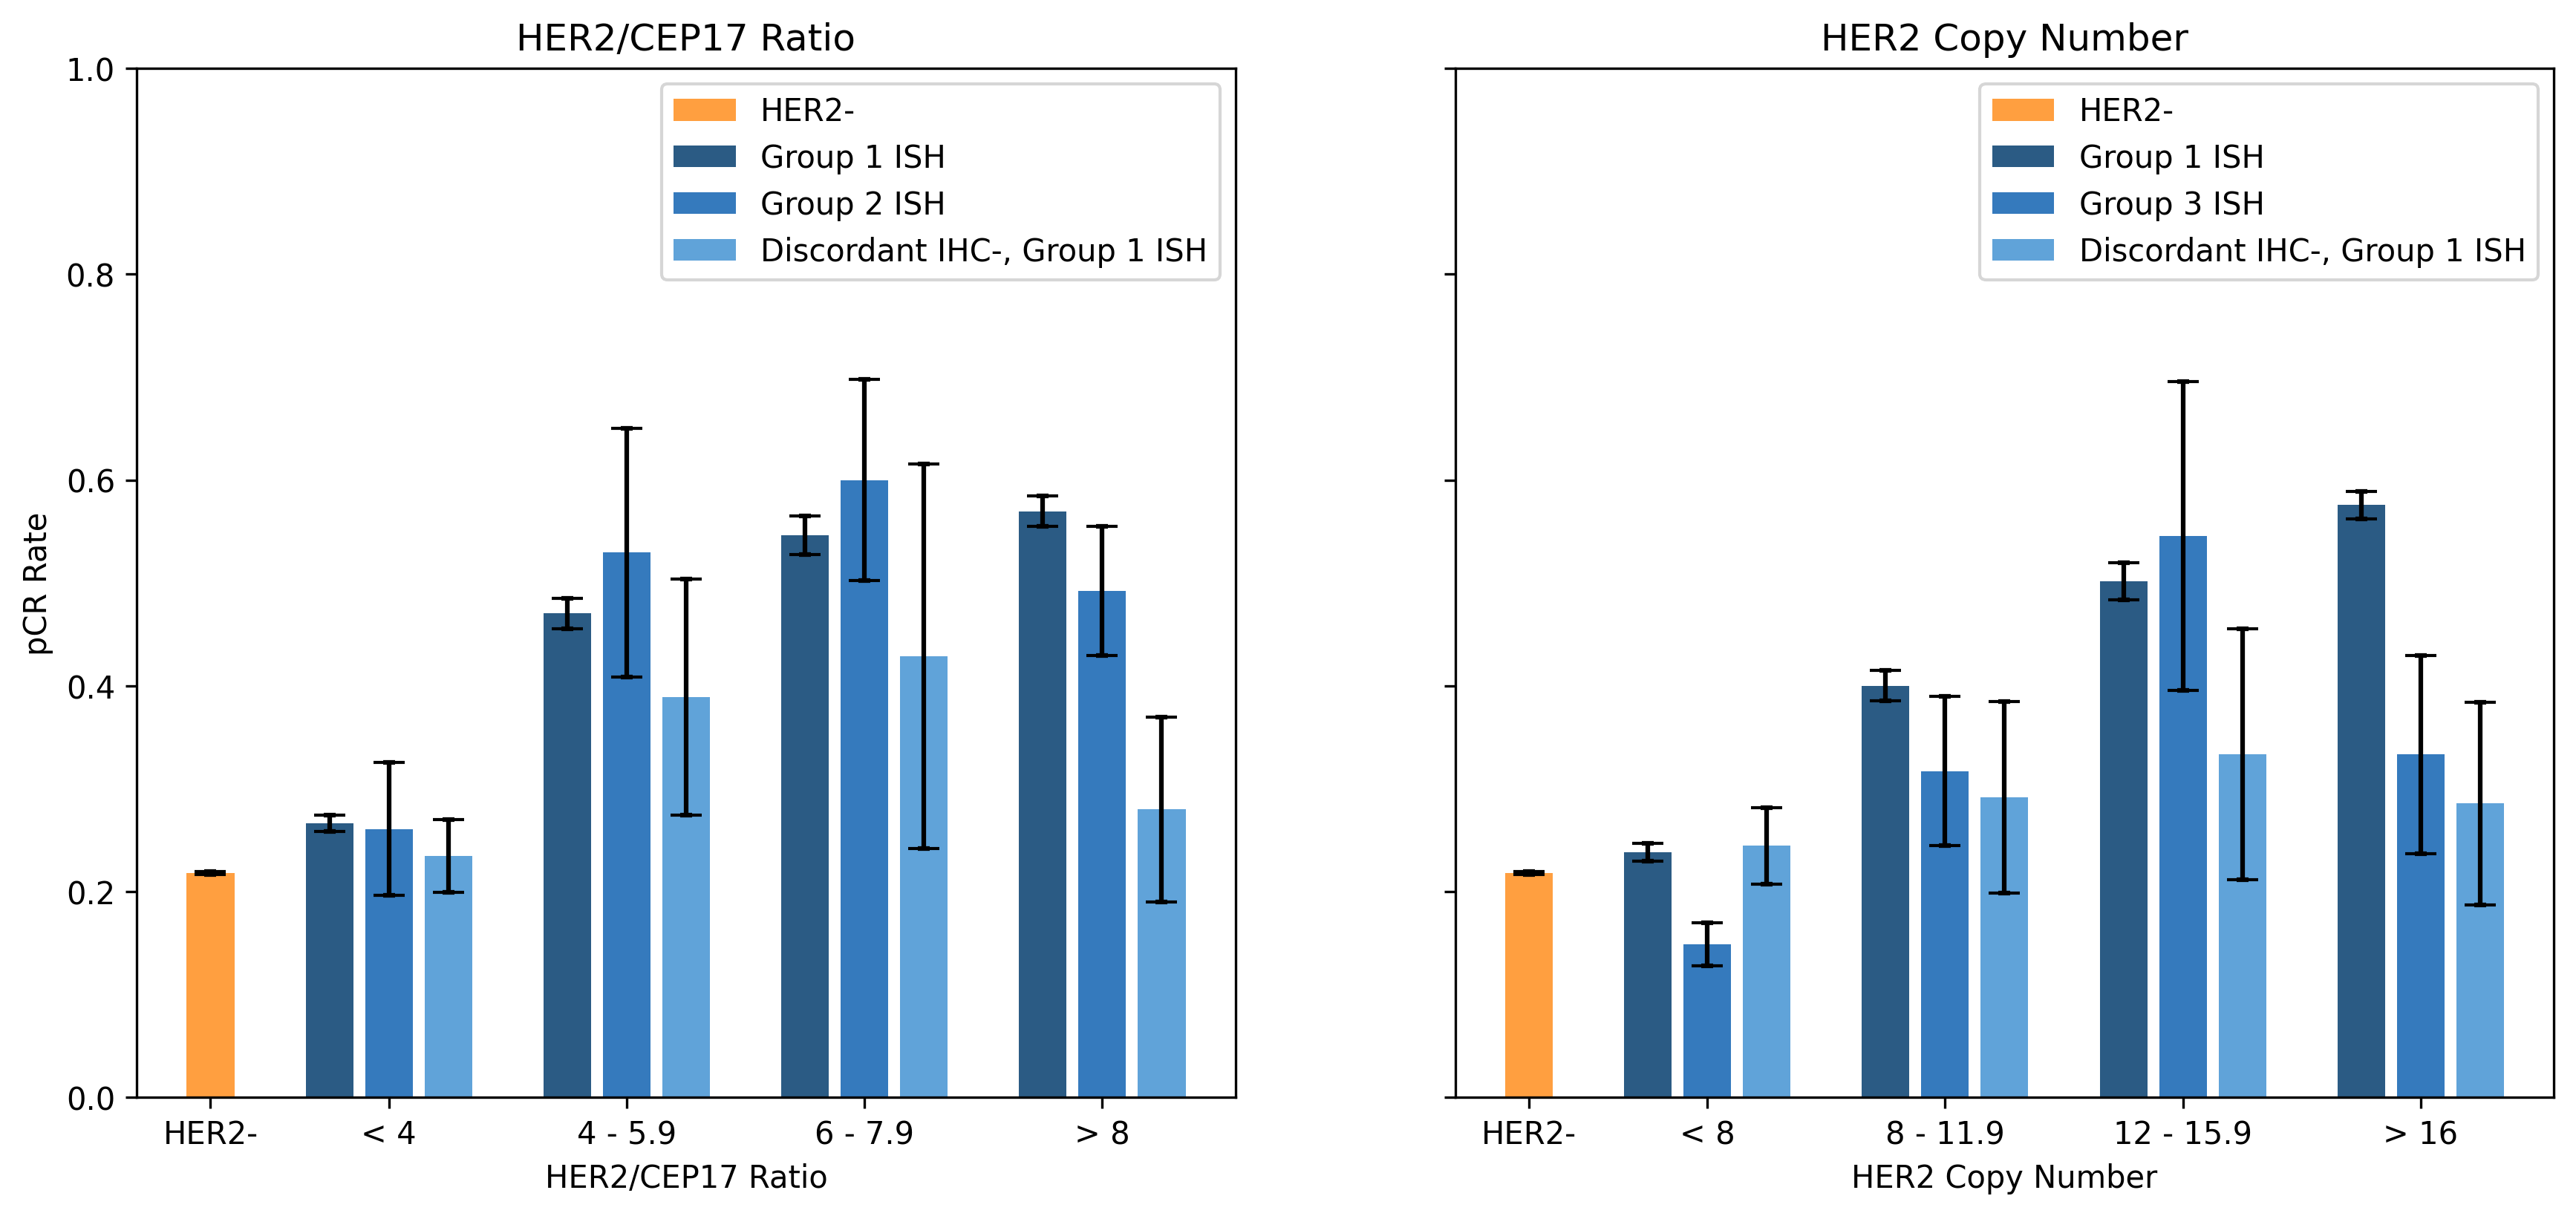

In [334]:
def plot_bars_supp3(rates, standard_errors, order, diagonal, ax, names, label2 = "Group 2 ISH"):
    """Generates bar plot using predefined color groupings for Group 1, 2, 3, and discordant patients by level of amplification on ISH
    Parameters
    ----------
    rates - pCR rates from bar_plot_stats
    standard_errors - SE from bar_plot_stats
    order - order to plot bars (listed as name of keys from rates/standard errors)
    diagonal - If true, plot labels at an angle for the x axis
    ax - provided axis to plot the graph
    
    Returns
    -------
    rates, standard_errors, sizes: tuple of dictionaries including the pCR rates, standard errors for pCR rates, and sample sizes for each category
    """
    custom_colors = ['#2B5B84','#2B5B84','#357abD','#2B5B84','#ff9f40','#ff9f40','#2B5B84','#2B5B84','#ff9f40','#2B5B84','#ff9f40','#ff9f40','#357abD','#ff9f40','#ff9f40']

    if ax is None:
        fig, ax = plt.subplots()

    ordered_rates = {key: rates[key] for key in order}
    ordered_errors = {key: standard_errors[key] for key in order}
    plot_range = [0, 2,3,4,6,7,8,10,11,12,14,15,16]
    group1index = [0]
    group2index = [1,4,7,10]
    group3index = [2,5,8,11]
    group4index = [3,6,9,12]
    bars1 = ax.bar([plot_range[x] for x in group1index], [list(ordered_rates.values())[x] for x in group1index], color='#ff9f40', label = 'HER2-')
    bars2 = ax.bar([plot_range[x] for x in group2index], [list(ordered_rates.values())[x] for x in group2index],  color = '#2B5B84', label = 'Group 1 ISH')
    bars3 = ax.bar([plot_range[x] for x in group3index], [list(ordered_rates.values())[x] for x in group3index],  color = '#357abD', label = label2)
    bars4 = ax.bar([plot_range[x] for x in group4index], [list(ordered_rates.values())[x] for x in group4index],  color = '#60a3d9', label = 'Discordant IHC-, Group 1 ISH')
    
    #bars = ax.bar([0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18], ordered_rates.values(), color=ordered_colors)
    
    errors = [list(ordered_errors.values())[x] for x in group1index]
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2.0
        error = errors[i]
        
        ax.errorbar(x, height, yerr=error, color='black', capsize=5)
        
        ax.hlines(y=height + error, xmin=x-0.1, xmax=x+0.1, color='black')
        ax.hlines(y=height - error, xmin=x-0.1, xmax=x+0.1, color='black')

    errors = [list(ordered_errors.values())[x] for x in group2index]
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2.0
        error = errors[i]
        
        ax.errorbar(x, height, yerr=error, color='black', capsize=5)
        
        ax.hlines(y=height + error, xmin=x-0.1, xmax=x+0.1, color='black')
        ax.hlines(y=height - error, xmin=x-0.1, xmax=x+0.1, color='black')

    errors = [list(ordered_errors.values())[x] for x in group3index]
    for i, bar in enumerate(bars3):
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2.0
        error = errors[i]
        
        ax.errorbar(x, height, yerr=error, color='black', capsize=5)
        
        ax.hlines(y=height + error, xmin=x-0.1, xmax=x+0.1, color='black')
        ax.hlines(y=height - error, xmin=x-0.1, xmax=x+0.1, color='black')
    errors = [list(ordered_errors.values())[x] for x in group4index]
    for i, bar in enumerate(bars4):
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2.0
        error = errors[i]
        
        ax.errorbar(x, height, yerr=error, color='black', capsize=5)
        
        ax.hlines(y=height + error, xmin=x-0.1, xmax=x+0.1, color='black')
        ax.hlines(y=height - error, xmin=x-0.1, xmax=x+0.1, color='black')
    ax.set_ylim(0, 1.0)
    if diagonal:
        ax.set_xticks([0, 3, 7, 11, 15])
        ax.set_xticklabels(names)
        
    if ax is None:
        plt.show()


#New plot with more bars
neoadj = df.copy()
neoadj = neoadj[neoadj.immuno.isin([0,1])]
neoadj = neoadj[(~neoadj.pcr.isna()) & (neoadj.neoadj_chemo == 1) & (((neoadj.neoadj_immuno == 1) & (neoadj.cat != 'C')) | ((neoadj.neoadj_immuno != 1) & (neoadj.cat == 'C'))) ]


bins = [0, 4, 6, 8, 999]
labels = ['HER2-', '< 4', '4 - 5.9','6 - 7.9','> 8']


neoadj = neoadj[(neoadj.cat4 == 'n') | (neoadj.asco_group == 1) | (neoadj.asco_group == 2) | (neoadj.asco_group == 3)]

neoadj['catnew'] = np.nan
neoadj.loc[neoadj.cat4 == 'n', 'catnew'] = 'n'
for ihc in [1, 2, 3]:
    for ish in [1,2,3,4]:
        if ihc == 1:
            neoadj.loc[(neoadj.cat == 'B') & (neoadj.her2.isin([0,1])) & (neoadj.her2ratio > bins[ish-1]) & (neoadj.her2ratio <= bins[ish]), 'catnew'] = str(ihc) + str(ish)
        elif ihc == 2:
            neoadj.loc[(neoadj.cat == 'A2') & (neoadj.her2ratio > bins[ish-1]) & (neoadj.her2ratio <= bins[ish]), 'catnew'] = str(ihc) + str(ish)
        elif ihc == 3:
            neoadj.loc[(neoadj.cat == 'AA') & (neoadj.her2ratio > bins[ish-1]) & (neoadj.her2ratio <= bins[ish]), 'catnew'] = str(ihc) + str(ish)

rates, standard_errors, sizes = bar_plot_stats(neoadj)
order = ['n','31','21','11','32','22','12','33','23','13','34','24','14']

names = ['HER2-', '< 4', '4 - 5.9', '6 - 7.9', '> 8']
fig, axs = plt.subplots(1, 2, dpi = 300, sharey = True, figsize = (14, 6))
axs[0].set_title("HER2/CEP17 Ratio")
axs[0].set_ylabel("pCR Rate")
axs[1].set_title("HER2 Copy Number")
plot_bars_supp3(rates, standard_errors,order,diagonal = True, ax = axs[0], names = names)
axs[0].legend()
axs[0].set_xlabel('HER2/CEP17 Ratio')
axs[1].set_xlabel('HER2 Copy Number')

bins = [0, 8, 12, 16, 999]
labels = ['HER2-', '< 8', '8 - 11.9', '12 - 15.9', '> 16']


neoadj['catnew'] = np.nan
neoadj.loc[neoadj.cat4 == 'n', 'catnew'] = 'n'
for ihc in [1, 2, 3]:
    for ish in [1,2,3,4]:
        if ihc == 1:
            neoadj.loc[(neoadj.cat == 'B') & (neoadj.her2.isin([0,1])) & (neoadj.her2copies > bins[ish-1]) & (neoadj.her2copies <= bins[ish]), 'catnew'] = str(ihc) + str(ish)
        elif ihc == 2:
            neoadj.loc[((neoadj.cat == 'A3') | (neoadj.cat == 'A3-2')) & (neoadj.her2copies > bins[ish-1]) & (neoadj.her2copies <= bins[ish]), 'catnew'] = str(ihc) + str(ish)
        elif ihc == 3:
            neoadj.loc[(neoadj.cat == 'AA') & (neoadj.her2copies > bins[ish-1]) & (neoadj.her2copies <= bins[ish]), 'catnew'] = str(ihc) + str(ish)

rates, standard_errors, sizes = bar_plot_stats(neoadj)
order = ['n','31','21','11','32','22','12','33','23','13','34','24','14']
#names = ['HER2-', '< 6', '6 - 7.9', '8 - 9.9', '> 10']
names = labels
rates, standard_errors, sizes = bar_plot_stats(neoadj)
plot_bars_supp3(rates, standard_errors,order,diagonal = True, ax = axs[1], names = names, label2 = "Group 3 ISH")
axs[1].legend()
plt.show()





### Logistic Regression on PCR

In [311]:
def setDummies(df, var, subset, missing_indicator = True, multiple_impute = False):
    """Generates dummy variable for columns in dataframe
    Parameters
    ----------
    df - input dataframe
    var - column to genrerate dummy variables for
    subset - list of values to genrate dummy variables for (i.e., for each element e in subset, create a dummy variable for cases where 'var' = e)
    missing_indicator - if True, fill empty elements with mean imputation
    multiple_impute - if True, fill emtpy elements with NaN
    
    Returns
    -------
    ret_cols - a list of the created dummy variables in the dataframe    
    """
    ret_cols = []
    if missing_indicator:
        df['missing_' + str(var)] = 0
        df.loc[df[var].isna(), 'missing_' + str(var)] = 1
    for v in subset:
        df[var + "_" + str(v)] = 0
        ret_cols += [var  + "_" +  str(v)]
        df.loc[df[var] == v, var  + "_" + str(v)] = 1
        if missing_indicator:
            df.loc[df[var].isna(), var  + "_" + str(v)] = df[var  + "_" + str(v)].mean()
        if multiple_impute:
            df.loc[df[var].isna(), var  + "_" + str(v)] = np.nan            
    return ret_cols

def parse_columns(df_subset, cols, ignore = [], include_stage4 = True, all_histologies = True, her2_categories = False, multiple_impute = True, missing_indicator = False, redo_impute = False, receptors = None, immuno_cat = False):
    """Generates dummy variable for columns in dataframe
    Parameters
    ----------
    df_subset - input dataframe
    cols - columns to parse
    ignore - columns to ignore for parsing purposes
    include_stage4 - if true, include a dummy variable for stage 4 (Set to false for early stage analyses)
    all_histologies - set to False to only analyze ductal vs lobular vs other (useful for sparse data)
    her2_categories - set to False if plan is to analyze HER2-low vs HER2-0, otherwise will include IHC 0 vs 1 vs 2
    multiple_impute - True for multiple imputation
    missing_indicator - True for mean imputation
    redo_impute - True if goal is to regenerate imputed dataframe (vs using saved dataframe)
    receptors - True to include ER+PR+, ER+PR-, ER-PR+, and TNBC as exclusive subgroups for the same set of dummy variables
    immuno_cat - allows for inclusion of subset of HER2+ cases receiving immunotherapy
    
    Returns
    -------
    df_subset - a parsed dataframe ready for logistic regression / Cox model analysis with proper dummy variables
    """
    if 'neoadj_immuno' in cols:
        df_subset[['neoadj_immuno']] = df_subset[['neoadj_immuno']].fillna(0)
        df_subset = df_subset[~df_subset.immuno.isna()]
    if (not multiple_impute) and (not missing_indicator):
        df_subset = df_subset[cols].dropna()
        #print('Dropping all "NA" values.')
    
    cols = [c for c in cols if c not in ignore]
    test_cols = []
    label_cols = []
    label_names = []
    if missing_indicator:
        for c in cols:
            if c not in ['alive', 'last_contact','her2']:
                if len(df_subset[df_subset[c].isna()].index) > 0:
                    test_cols += ['missing_' + c]
                    label_cols += [['missing_' + c]]
                    label_names += [['Missing ' + c]]
            
    if 'age' in cols:
        df_subset['age'] = df_subset['age'] / 10
        test_cols += ['age']
        label_cols += [['age']]
        label_names += [['Age (per year)']]
        applyMissing(df_subset, 'age', missing_indicator = missing_indicator, multiple_impute = multiple_impute)

    if 'sex' in cols:
        t = setDummies(df_subset, 'sex', {2}, missing_indicator)
        test_cols += t
        label_cols += [t]
        label_names += [['Female', 'Male']]
        
    if 'cdcc' in cols:
        test_cols += ['cdcc']
        label_cols += [['cdcc']]
        label_names += [['CDCC 0', 'CDCC > 0']]
        df_subset['cdcc_high'] = 0
        df_subset.loc[df_subset.cdcc.astype(float) > 0, 'cdcc_high'] = 1
        applyMissing(df_subset, 'cdcc', ['cdcc_high'], missing_indicator = missing_indicator, multiple_impute = multiple_impute)

    if 'immuno' in cols:
        df_subset = df_subset[df_subset.immuno.isin([0,1])]
        t = setDummies(df_subset, 'immuno', {1}, missing_indicator)
        test_cols += t
        label_cols += [t]
        label_names += [['No Immunotherapy', 'Immunotherapy']]

    if 'neoadj_immuno' in cols:
        test_cols += ['neoadj_immuno_cat']
        label_cols += [['neoadj_immuno_cat']]
        label_names += [['No Immunotherapy', 'Immunotherapy']]
        df_subset['neoadj_immuno_cat'] = 0
        df_subset.loc[df_subset.neoadj_immuno == 1, 'neoadj_immuno_cat'] = 1
        
        
    if 'facility' in cols:
        t = setDummies(df_subset, 'facility', {2,3,4}, missing_indicator = missing_indicator, multiple_impute = multiple_impute)
        test_cols += t
        label_cols += [t]
        label_names += [['Community Cancer Program', 'Comprehensive Comunity Cancer Program', 'Academic / Research', 'Integrated Network Cancer Program']]

    if 'receptors' in cols:
        if len(df_subset[df_subset.receptors.astype(float)==0].index > 0) and receptors is None:
            test_cols += ['prneg', 'erneg', 'tnbc']
            label_cols += [['prneg', 'erneg', 'tnbc']]
            label_names += [['ER+/PR+', 'ER+/PR-', 'ER-/PR+', 'TNBC']]
            df_subset['prneg'] = 0
            df_subset['erneg'] = 0
            df_subset['tnbc'] = 0
            df_subset.loc[df_subset.receptors.astype(float) == 100, 'prneg'] = 1
            df_subset.loc[df_subset.receptors.astype(float) == 10, 'erneg'] = 1
            df_subset.loc[df_subset.receptors.astype(float) == 0, 'tnbc'] = 1
            applyMissing(df_subset, 'receptors', ['prneg', 'erneg', 'tnbc'], missing_indicator = missing_indicator, multiple_impute = multiple_impute)
        else:
            test_cols += ['prneg', 'erneg']
            label_cols += [['prneg', 'erneg']]
            label_names += [['ER+/PR+', 'ER+/PR-', 'ER-/PR+']]
            df_subset['prneg'] = 0
            df_subset['erneg'] = 0
            df_subset.loc[df_subset.receptors.astype(float) == 100, 'prneg'] = 1
            df_subset.loc[df_subset.receptors.astype(float) == 10, 'erneg'] = 1
            applyMissing(df_subset, 'receptors', ['prneg', 'erneg'], missing_indicator = missing_indicator, multiple_impute = multiple_impute)

            
    if 'er_num' in cols:
        df_subset['er_num'] = df_subset['er_num'] / 10
        test_cols += ['er_num']
        label_cols += [['er_num']]
        label_names += [['ER (per 10% expression)']]
        applyMissing(df_subset, 'er_num', missing_indicator = missing_indicator, multiple_impute = multiple_impute)

    if 'pr_num' in cols:
        df_subset['pr_num'] = df_subset['pr_num'] / 10
        test_cols += ['pr_num']
        label_cols += [['pr_num']]
        label_names += [['PR (per 10% expression)']]
        applyMissing(df_subset, 'pr_num', missing_indicator = missing_indicator, multiple_impute = multiple_impute)

    if 'ki67_num' in cols:
        df_subset['ki67_num'] = df_subset['ki67_num'] / 10
        test_cols += ['ki67_num']
        label_cols += [['ki67_num']]
        label_names += [['Ki67 (per 10% expression)']]
        applyMissing(df_subset, 'ki67_num', missing_indicator = missing_indicator, multiple_impute = multiple_impute)

    if 'her2' in cols:
        if her2_categories:
            test_cols += ['her2_1', 'her2_2']
            label_cols += [['her2_1', 'her2_2']]
            label_names += [['HER2 0', 'HER2 1+', 'HER2 2+']]
            df_subset['her2_1'] = 0
            df_subset['her2_2'] = 0
            df_subset.loc[df_subset.her2.astype(float) == 1, 'her2_1'] = 1        
            df_subset.loc[df_subset.her2.astype(float) == 2, 'her2_2'] = 1
        else:
            test_cols += ['her2low']
            label_cols += [['her2low']]
            label_names += [['HER2 0', 'HER2 Low']]
            df_subset['her2low'] = 0
            df_subset.loc[df_subset.her2.astype(float) > 0, 'her2low'] = 1

    if 'her2ratio' in cols:
        test_cols += ['her2ratio']
        label_cols += [['her2ratio']]
        label_names += [['HER2 Ratio (per 1.0 increase)']]
        applyMissing(df_subset, 'her2ratio', missing_indicator = missing_indicator, multiple_impute = multiple_impute)

    if 'her2copies' in cols:
        test_cols += ['her2copies']
        label_cols += [['her2copies']]
        label_names += [['HER2 Count (per 1.0 increase)']]
        applyMissing(df_subset, 'her2copies', missing_indicator = missing_indicator, multiple_impute = multiple_impute)
    
    if 'odx' in cols:
        test_cols += ['odx']
        label_cols += [['odx']]
        label_names += [['OncotypeDx (per 1 point increase)']]
        applyMissing(df_subset, 'odx', missing_indicator = missing_indicator, multiple_impute = multiple_impute)

    if 'race_parse' in cols:
        t = setDummies(df_subset, 'race_parse', {1,2,3,4,5}, missing_indicator = missing_indicator, multiple_impute = multiple_impute)
        test_cols += t
        label_cols += [t]
        label_names += [['Non-Hispanic White', 'Non-Hispanic Black', 'Hispanic', 'Other', 'Native American', 'Asian / Pacific Islander']]

    if 'tumor_size' in cols:
        test_cols += ['tumor_size']
        label_cols += [['tumor_size']]
        label_names += [['Tumor Size (per mm increase)']]
        applyMissing(df_subset, 'tumor_size', missing_indicator = missing_indicator, multiple_impute = multiple_impute)

    if 'regional_nodes_positive' in cols:
        test_cols += ['regional_nodes_positive']
        label_cols += [['regional_nodes_positive']]
        label_names += [['Nodes Positive (per # of involved nodes)']]
        applyMissing(df_subset, 'regional_nodes_positive', missing_indicator = missing_indicator, multiple_impute = multiple_impute)
        
    if 'tnm_clin_t' in cols:
        test_cols += ['t2', 't3', 't4']
        label_cols += [['t2', 't3', 't4']]
        label_names += [['T1', 'T2', 'T3', 'T4']]
        if not missing_indicator and not multiple_impute:
            df_subset.loc[df_subset.tnm_clin_t.str.contains('1') | df_subset.tnm_clin_t.str.contains('2') | df_subset.tnm_clin_t.str.contains('3') | df_subset.tnm_clin_t.str.contains('4')].reset_index()
        
        df_subset['t2'] = 0
        df_subset['t3'] = 0
        df_subset['t4'] = 0        
        df_subset.loc[df_subset.tnm_clin_t.str.contains('2'), 't2'] = 1
        df_subset.loc[df_subset.tnm_clin_t.str.contains('3'), 't3'] = 1
        df_subset.loc[df_subset.tnm_clin_t.str.contains('4'), 't4'] = 1
        if missing_indicator or multiple_impute:
            df_subset.loc[~(df_subset.tnm_clin_t.str.contains('1') | df_subset.tnm_clin_t.str.contains('2') | df_subset.tnm_clin_t.str.contains('3') | df_subset.tnm_clin_t.str.contains('4')), 'tnm_clin_t'] = np.nan
            applyMissing(df_subset, 'tnm_clin_t', ['t2', 't3', 't4'], missing_indicator = missing_indicator, multiple_impute = multiple_impute)

    if 'tnm_clin_n' in cols:
        test_cols += ['n1', 'n2', 'n3']
        label_cols += [['n1', 'n2', 'n3']]
        label_names += [['N0', 'N1', 'N2', 'N3']]
        if not missing_indicator and not multiple_impute:
            df_subset = df_subset[df_subset.tnm_clin_n.str.contains('0') | df_subset.tnm_clin_n.str.contains('1') | df_subset.tnm_clin_n.str.contains('2') | df_subset.tnm_clin_n.str.contains('3')].reset_index()
        df_subset['n1'] = 0
        df_subset['n2'] = 0
        df_subset['n3'] = 0
        df_subset.loc[df_subset.tnm_clin_n.str.contains('1'), 'n1'] = 1
        df_subset.loc[df_subset.tnm_clin_n.str.contains('2'), 'n2'] = 1
        df_subset.loc[df_subset.tnm_clin_n.str.contains('3'), 'n3'] = 1
        if missing_indicator or multiple_impute:
            df_subset.loc[~(df_subset.tnm_clin_n.str.contains('1') | df_subset.tnm_clin_n.str.contains('2') | df_subset.tnm_clin_n.str.contains('3') | df_subset.tnm_clin_n.str.contains('0')), 'tnm_clin_n'] = np.nan
            applyMissing(df_subset, 'tnm_clin_n', ['n1', 'n2', 'n3'], missing_indicator = missing_indicator, multiple_impute = multiple_impute)

    if 't_stage' in cols:
        if not missing_indicator and not multiple_impute:
            df_subset = df_subset[df_subset.t_stage.isin([1,2,3,4])].reset_index()
        test_cols += ['t2', 't3', 't4']
        label_cols += [['t2', 't3', 't4']]
        label_names += [['T1', 'T2', 'T3', 'T4']]
        df_subset['t2'] = 0
        df_subset['t3'] = 0
        df_subset['t4'] = 0
        df_subset.loc[df_subset.t_stage == 2, 't2'] = 1
        df_subset.loc[df_subset.t_stage == 3, 't3'] = 1
        df_subset.loc[df_subset.t_stage == 4, 't4'] = 1
        if missing_indicator or multiple_impute:
            df_subset.loc[~(df_subset.t_stage.isin([1,2,3,4])), 't_stage'] = np.nan
            applyMissing(df_subset, 't_stage', ['t2', 't3', 't4'], missing_indicator = missing_indicator, multiple_impute = multiple_impute)

    if 'n_stage' in cols:
        test_cols += ['n1', 'n2', 'n3']
        label_cols += [['n1', 'n2', 'n3']]
        label_names += [['N0', 'N1', 'N2', 'N3']]
        if not missing_indicator and not multiple_impute:
            df_subset = df_subset[df_subset.n_stage.isin([0,1,2,3])].reset_index()
        df_subset['n1'] = 0
        df_subset['n2'] = 0
        df_subset['n3'] = 0
        df_subset.loc[df_subset.n_stage == 1, 'n1'] = 1
        df_subset.loc[df_subset.n_stage == 2, 'n2'] = 1
        df_subset.loc[df_subset.n_stage == 3, 'n3'] = 1
        if missing_indicator or multiple_impute:
            df_subset.loc[~(df_subset.n_stage.isin([0,1,2,3])), 'n_stage'] = np.nan
            applyMissing(df_subset, 'n_stage', ['n1', 'n2', 'n3'], missing_indicator = missing_indicator, multiple_impute = multiple_impute)

    if 'stage' in cols:
        if include_stage4:
            t = setDummies(df_subset, 'stage', {2,3,4},  missing_indicator = missing_indicator, multiple_impute = multiple_impute)
            test_cols += t
            label_cols += [t]
            label_names += [['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']]
        else:
            t = setDummies(df_subset, 'stage', {2,3}, missing_indicator = missing_indicator, multiple_impute = multiple_impute)
            test_cols += t
            label_cols += [t]
            label_names += [['Stage 1', 'Stage 2', 'Stage 3']]
            
    if 'grade' in cols:
        t = setDummies(df_subset, 'grade', {2,3},  missing_indicator = missing_indicator, multiple_impute = multiple_impute)
        test_cols += t
        label_cols += [t]
        label_names += [['Grade 1', 'Grade 2', 'Grade 3']]
        
    if 'histology' in cols:
        if all_histologies:
            t = setDummies(df_subset, 'histology', {1,2,3,4,5,6,7,8,9,10}, missing_indicator = missing_indicator, multiple_impute = multiple_impute)
            test_cols += t + ['histology_others']
            label_cols += [t + ['histology_others']]
            df_subset['histology_others'] = 0
            df_subset.loc[~df_subset.histology.isin([0,1,2,3,4,5,6,7,8,9,10]), 'histology_others'] = 1
            label_names += [['Ductal', 'Lobular', 'Ductal and Lobular', 'Mucinous', 'Papillary', 'Tubular', 'Inflammatory', 'Medullary', 'Metaplastic', 'Paget Disease', 'Sarcoma', 'Other']]

        else:
            t = setDummies(df_subset, 'histology', {1,2,3}, missing_indicator = missing_indicator, multiple_impute = multiple_impute)
            test_cols += t + ['histology_others']
            label_cols += [t + ['histology_others']]
            df_subset['histology_others'] = 0
            df_subset.loc[~df_subset.histology.isin([0,1,2,3]), 'histology_others'] = 1
            label_names += [['Ductal', 'Lobular', 'Ductal and Lobular', 'Mucinous']]

    if 'er' in cols:
        t = setDummies(df_subset, 'er', {'-'},  missing_indicator = missing_indicator, multiple_impute = multiple_impute)
        test_cols += t
        label_cols += [t]
        label_names += [['ER +','ER -']]

    if 'pr' in cols:
        t = setDummies(df_subset, 'pr', {'-'},  missing_indicator = missing_indicator, multiple_impute = multiple_impute)
        test_cols += t
        label_cols += [t]
        label_names += [['PR +','PR -']]

    if 'cat' in cols:
        #t = setDummies(df_subset, 'cat', ['AA','A2','A3','A3-2','A4','B','D'], missing_indicator = missing_indicator, multiple_impute = multiple_impute)
        #test_cols += t
        #label_cols += [t]
        #label_names += [['HER2-','HER2+','Group 2/IHC+','Group 3/IHC 3+','Group 3/IHC 2+', 'Group 4/IHC+','ISH+/IHC-','ISH-/IHC+']]
        t = setDummies(df_subset, 'cat', ['AA','A2','A3', 'A3-2', 'A4','B','D'], missing_indicator = missing_indicator, multiple_impute = multiple_impute)
        test_cols += t
        label_cols += [t]
        label_names += [['HER2-','HER2+','Group 2/IHC+','Group 3/IHC 3+', 'Group 3/IHC 2+', 'Group 4/IHC+','ISH+/IHC-','ISH-/IHC+']]

    if 'cat_no3' in cols:
        #t = setDummies(df_subset, 'cat', ['AA','A2','A3','A3-2','A4','B','D'], missing_indicator = missing_indicator, multiple_impute = multiple_impute)
        #test_cols += t
        #label_cols += [t]
        #label_names += [['HER2-','HER2+','Group 2/IHC+','Group 3/IHC 3+','Group 3/IHC 2+', 'Group 4/IHC+','ISH+/IHC-','ISH-/IHC+']]
        t = setDummies(df_subset, 'cat_no3', ['AA','A2','A3', 'A4','B','D'], missing_indicator = missing_indicator, multiple_impute = multiple_impute)
        test_cols += t
        label_cols += [t]
        label_names += [['HER2-','HER2+','Group 2/IHC+','Group 3/IHC 2-33+', 'Group 4/IHC+','ISH+/IHC-','ISH-/IHC+']]

    if immuno_cat:
        #t = setDummies(df_subset, 'cat', ['AA','A2','A3','A3-2','A4','B','D'], missing_indicator = missing_indicator, multiple_impute = multiple_impute)
        #test_cols += t
        #label_cols += [t]
        #label_names += [['HER2-','HER2+','Group 2/IHC+','Group 3/IHC 3+','Group 3/IHC 2+', 'Group 4/IHC+','ISH+/IHC-','ISH-/IHC+']]
        t = []
        for var in ['AA','A2','A3', 'A3-2', 'A4','B','D']:
            
            col_name = "immuno_cat_" + var
            df_subset[col_name] = 0
            df_subset.loc[(df_subset.cat == var) & (df_subset.neoadj_immuno == 1), col_name] = 1
            t += [col_name]
        test_cols += t
        label_cols += [t]
        label_names += [['HER2- Immuno','HER2+ Immuno','Group 2/IHC+ Immuno','Group 3/IHC 3+ Immuno', 'Group 3/IHC 2+ Immuno', 'Group 4/IHC+ Immuno','ISH+/IHC-','ISH-/IHC+ Immuno']]

        
    if 'cat_pos' in cols:
        t = setDummies(df_subset, 'cat_pos', {'C','A2','A3','A4','B','D','E'}, missing_indicator = missing_indicator, multiple_impute = multiple_impute)
        test_cols += t
        label_cols += [t]
        label_names += [['HER2+','HER2-','Group 2/IHC+','Group 3/IHC+','Group 4/IHC+','ISH+/IHC-','ISH-/IHC+','Group 2,3,4/IHC-']]


    if 'cat4' in cols:
        t = setDummies(df_subset, 'cat4', {'p','pn','np'}, missing_indicator = missing_indicator, multiple_impute = multiple_impute)
        test_cols += t
        label_cols += [t]
        label_names += [['HER2-','HER2+','IHC-/ISH+','IHC+/ISH-']]

    if 'cat4_pos' in cols:
        t = setDummies(df_subset, 'cat4_pos', {'n','pn','np'}, missing_indicator = missing_indicator, multiple_impute = multiple_impute)
        test_cols += t
        label_cols += [t]
        label_names += [['HER2+','HER2-','IHC-/ISH+','IHC+/ISH-']]


    if multiple_impute:
        global saved_impute
        if (saved_impute is not None) and (not redo_impute):
            print("Using saved imputation")
            df_subset = saved_impute.copy()
        else:
            print("Redoing imputation")
            from sklearn.experimental import enable_iterative_imputer
            from sklearn.impute import IterativeImputer
            imp = IterativeImputer(max_iter=100, random_state=0, verbose = 2, skip_complete=True)
            saved_impute = df_subset.copy()
            print(len(df_subset.index))
            saved_impute[test_cols] = imp.fit_transform(saved_impute[test_cols])
            print(len(saved_impute.index))

    return df_subset, test_cols, label_cols, label_names


def logistic_regression(df_subset1, cols, all_histologies = True, her2_categories = False, missing_indicator = False, multiple_impute = True, receptors = None, csv_filename=None, immuno_cat = False, io_string = False):
    """Calculates odds ratios for target variables
    Parameters
    ----------
    df_subset1 - input dataframe
    cols - columns to parse
    all_histologies - set to False to only analyze ductal vs lobular vs other (useful for sparse data)
    her2_categories - set to False if plan is to analyze HER2-low vs HER2-0, otherwise will include IHC 0 vs 1 vs 2
    multiple_impute - True for multiple imputation
    missing_indicator - True for mean imputation
    receptors - True to include ER+PR+, ER+PR-, ER-PR+, and TNBC as exclusive subgroups for the same set of dummy variables
    immuno_cat - allows for inclusion of subset of HER2+ cases receiving immunotherapy
    csv_filename - file to save logistic regression
    io_string - if true, perform analysis for immunotherapy treated vs untreated cases within provided cohort
       
    """
    df_subset2 = df_subset1.copy()
    
    df_subset, test_cols, label_cols, label_names = parse_columns(df_subset2, cols, ignore = ['pCR'], include_stage4 = False, all_histologies = all_histologies, her2_categories = her2_categories, missing_indicator = missing_indicator, multiple_impute = multiple_impute, receptors = receptors, immuno_cat = immuno_cat)
    
    if multiple_impute:
        if receptors is not None:
            if receptors == 'tnbc':
                df_subset = df_subset[df.receptors == 0]
            else:
                df_subset = df_subset[df.receptors > 0]
        df_subset = df_subset[(df.neoadj_chemo == 1) & (df.stage < 4)]
        df_subset = df_subset.dropna(subset = ['pcr']).reset_index()
    
    df_subset['const'] = 1
    test_cols += ['const']

    Xtrain = df_subset[test_cols]
    ytrain = df_subset[['pcr']]
    log_reg = sm.Logit(ytrain, Xtrain).fit(disp = 0)
    #print(log_reg.summary())
    #Print IO PCR String
    io_string = False
    if io_string:
        pcr_str = str(len(df_subset[df_subset.neoadj_immuno_cat == 0])) + ", " + str(round(100 * df_subset[df_subset.neoadj_immuno_cat == 0].pcr.mean(), 1)) + ", "
        pcr_str += str(len(df_subset[df_subset.neoadj_immuno_cat == 1])) + ", " + str(round(100 * df_subset[df_subset.neoadj_immuno_cat == 1].pcr.mean(), 1)) + ", "

        for l, n in zip(label_cols, label_names):
            if len(n) == 1:
                print(n[0] + "," + stringBeta(log_reg, l[0]))
            if len(n) > 1:
                #print(n[0] + ",1.00 (ref.),-")
                for l_sub, n_sub in zip(l, n[1:]):
                    print(pcr_str + stringBeta(log_reg, l_sub, 2))
    else:
        for l, n in zip(label_cols, label_names):
            if len(n) == 1:
                print(n[0] + "," + stringBeta(log_reg, l[0]))
            if len(n) > 1:
                #print(n[0] + ",1.00 (ref.),-")
                for l_sub, n_sub in zip(l, n[1:]):
                    print( n_sub + "," + stringBeta(log_reg, l_sub, 2))

    
    
    if csv_filename:
        summary_table = log_reg.summary().tables[1]
        summary_df = pd.DataFrame(summary_table.data)
        summary_df.columns = summary_df.iloc[0]
        summary_df = summary_df.drop(0)
        summary_df['coef'] = pd.to_numeric(summary_df['coef'])
        summary_df['odds_ratio'] = np.exp(summary_df['coef'])
        summary_df['[0.025'] = pd.to_numeric(summary_df['[0.025'], errors='coerce')
        summary_df['0.975]'] = pd.to_numeric(summary_df['0.975]'], errors='coerce')
        summary_df['odds_ratio_confidence_lower'] = np.exp(summary_df['[0.025'])
        summary_df['odds_ratio_confidence_upper'] = np.exp(summary_df['0.975]'])
        cols = summary_df.columns.tolist()
        cols.insert(cols.index('coef') + 1, cols.pop(cols.index('odds_ratio')))
        summary_df = summary_df[cols]
        summary_df.to_csv(csv_filename, index=False)



### Logistic Regression for pCR Compared to HER2+

In [316]:
neoadj = df.copy()
neoadj.immuno.isin([0,1])
neoadj = neoadj[(~neoadj.pcr.isna()) & (neoadj.neoadj_chemo == 1) & (((neoadj.neoadj_immuno == 1) & (neoadj.cat != 'C')) | ((neoadj.neoadj_immuno != 1) & (neoadj.cat == 'C'))) ]


print("Logistic Regression, univariable")
logistic_regression(neoadj, ['cat', 'pcr'], her2_categories = her2_cat, multiple_impute = False, all_histologies = False, csv_filename='logistic_regression_1.csv')

print()
print("Logistic Regression, all covariables except numeric ER/PR")
logistic_regression(neoadj, ['cat', 'pcr', 'age', 'sex', 'race_parse', 'cdcc', 'facility', 't_stage', 'n_stage', 'grade', 'histology', 'er', 'pr'], her2_categories = her2_cat, multiple_impute = False, all_histologies = False, csv_filename='logistic_regression_2.csv')

print()
print("Logistic Regression, all covariables including numeric ER/PR")
logistic_regression(neoadj, ['cat', 'pcr', 'age', 'sex', 'race_parse', 'cdcc', 'facility', 't_stage', 'n_stage', 'grade', 'histology', 'er_num', 'pr_num'], her2_categories = her2_cat, multiple_impute = False, all_histologies = False, csv_filename='logistic_regression_3.csv')


Logistic Regression, univariable
HER2+,3.53 (3.45 - 3.62),< 0.001,
Group 2/IHC+,2.87 (2.08 - 3.96),< 0.001,
Group 3/IHC 3+,1.72 (1.01 - 2.92),0.05,
Group 3/IHC 2+,0.71 (0.53 - 0.96),0.03,
Group 4/IHC+,0.45 (0.23 - 0.9),0.02,
ISH+/IHC-,1.28 (0.93 - 1.76),0.14,
ISH-/IHC+,0.41 (0.22 - 0.76),0.005,

Logistic Regression, all covariables except numeric ER/PR
Age (per year),0.84 (0.83 - 0.86),< 0.001,
Male,1.74 (1.36 - 2.23),< 0.001,
CDCC > 0,0.91 (0.88 - 0.93),< 0.001,
Comprehensive Comunity Cancer Program,1.02 (0.95 - 1.09),0.63,
Academic / Research,1.06 (0.99 - 1.13),0.11,
Integrated Network Cancer Program,1.05 (0.98 - 1.12),0.19,
Non-Hispanic Black,0.92 (0.89 - 0.96),< 0.001,
Hispanic,1.08 (1.02 - 1.14),0.004,
Other,0.99 (0.82 - 1.18),0.88,
Native American,1.06 (0.83 - 1.34),0.66,
Asian / Pacific Islander,1.03 (0.96 - 1.1),0.44,
T2,0.82 (0.79 - 0.85),< 0.001,
T3,0.6 (0.57 - 0.63),< 0.001,
T4,0.54 (0.51 - 0.58),< 0.001,
N1,0.75 (0.73 - 0.78),< 0.001,
N2,0.67 (0.62 - 0.71),< 0.001,
N3,0.73 

### Logistic Regression for pCR Compared to HER2-targeted therapy untreated cases

In [313]:
neoadj = df.copy()
neoadj = neoadj[neoadj.immuno.isin([0,1])]
neoadj = neoadj[(~neoadj.pcr.isna()) & (neoadj.neoadj_chemo == 1)]
key_mapping = {
'AA': 'Group 1 and/or IHC 3+',
'A2': 'Group 2 IHC 3+',
'A3': 'Group 3 IHC 3+',
'A3-2': 'Group 3 IHC 2+',
'A4': 'Group 4 IHC 3+',
'B': 'ISH+/IHC-',
'C': 'HER2-',
'D': 'ISH-/IHC+',
}
for c in ['AA','A2', 'A3', 'A3-2', 'A4', 'B', 'D']:
    try:
        print(key_mapping[c], end = " ")
        logistic_regression(neoadj[(neoadj.cat == c)],  ['neoadj_immuno', 'pcr'], her2_categories = her2_cat, multiple_impute = False, all_histologies = False, io_string = True)
    except:
        print("unable")

Group 1 and/or IHC 3+ Immunotherapy,1.51 (1.43 - 1.61),< 0.001,
Group 2 IHC 3+ Immunotherapy,1.95 (0.84 - 4.51),0.12,
Group 3 IHC 3+ Immunotherapy,0.95 (0.16 - 5.64),0.96,
Group 3 IHC 2+ Immunotherapy,1.05 (0.57 - 1.93),0.89,
Group 4 IHC 3+ Immunotherapy,1.38 (0.16 - 11.94),0.77,
ISH+/IHC- Immunotherapy,1.42 (0.78 - 2.57),0.25,
ISH-/IHC+ Immunotherapy,0.44 (0.17 - 1.15),0.1,


# Survival cohort

### Cox Model on Censored Survival

In [327]:

def stringMST(kmf, rnd_fig = 1):
    """Calculates median survival
    Parameters
    ----------
    kmf - KaplanMeierFitter object
    rnd_fig - how many figures to round to
    
    Returns
    -------
    string with the median survival time and confidence intervals
    """

    from lifelines.utils import median_survival_times
    mst = kmf.median_survival_time_
    mst_ci = str(median_survival_times(kmf.confidence_interval_)).split("                  ")
    lb = str(round(float(mst_ci[1].strip()), rnd_fig)).replace("inf", "NR")
    ub = str(round(float(mst_ci[2].strip()), rnd_fig)).replace("inf", "NR")
    return str(round(kmf.median_survival_time_, rnd_fig)).replace("inf", "NR") + " (" + lb + " - " + ub + "),"

def stringSurvTime(kmf, yr = 3, rnd_fig = 1):
    """Calculates survival time at a fixed point
    Parameters
    ----------
    kmf - KaplanMeierFitter object
    yr - year to claculate survival time string
    rnd_fig - how many figures to round to
    
    Returns
    -------
    string with the n-year survial time and confidence intervals
    """
    siga = kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*yr]
    return str(round(100*kmf.predict(12*yr),rnd_fig)) + " (" + str(round(100*siga.values.tolist()[0][0],rnd_fig)) + " - " +  str(round(100*siga.values.tolist()[0][1],rnd_fig))  + "),"

def cphModelMultivariate(df_subset, cols, all_histologies = False, her2_categories = False, stage = None, receptors = None, missing_indicator = False, multiple_impute = True, csv_filename=None, print_immuno = False, print_mst = False):
    """Calculates hazard ratios for target variables
    Parameters
    ----------
    df_subset1 - input dataframe
    cols - columns to parse
    all_histologies - set to False to only analyze ductal vs lobular vs other (useful for sparse data)
    her2_categories - set to False if plan is to analyze HER2-low vs HER2-0, otherwise will include IHC 0 vs 1 vs 2
    multiple_impute - True for multiple imputation
    missing_indicator - True for mean imputation
    receptors - True to include ER+PR+, ER+PR-, ER-PR+, and TNBC as exclusive subgroups for the same set of dummy variables
    immuno_cat - allows for inclusion of subset of HER2+ cases receiving immunotherapy
    csv_filename - file to save Cox regression
    print_immuno - if true, perform analysis for immunotherapy treated vs untreated cases within provided cohort
    print_mst - if true, prints median survival time. if false, prints 3 year OS
       
    """
    df_subset, test_cols, label_cols, label_names = parse_columns(df_subset, cols, all_histologies = all_histologies, her2_categories = her2_categories, missing_indicator = False, multiple_impute = multiple_impute, receptors = receptors)
    df_subset = df_subset.copy().dropna(subset=['alive', 'last_contact'])
    
    if stage is not None:
        df_subset = df_subset[df_subset.stage == stage]
    if receptors is not None:
        if receptors == 'tnbc':
            df_subset = df_subset[df_subset.receptors.astype(float) == 0]
        else:
            df_subset = df_subset[df_subset.receptors.astype(float) > 0]


    test_cols += ['alive', 'last_contact']
    cph = CoxPHFitter(penalizer=0.1)
    df_cph = df_subset[test_cols]
    cph.fit(df_cph, "last_contact", event_col = "alive")
    if print_immuno:
        df_cph_0 = df_cph[df_cph.immuno_1 == 0]
        kmf = KaplanMeierFitter()
        kmf.fit(df_cph_0['last_contact'], df_cph_0['alive'])
        if print_mst:
            strPrint = str(len(df_cph_0.index)) + "," + stringMST(kmf)
        else:
            strPrint = str(len(df_cph_0.index)) + "," + stringSurvTime(kmf, yr = 3)
        df_cph_1 = df_cph[df_cph.immuno_1 == 1]
        kmf = KaplanMeierFitter()
        kmf.fit(df_cph_1['last_contact'], df_cph_1['alive'])
        if print_mst:
            strPrint += str(len(df_cph_1.index)) + "," + stringMST(kmf)
        else:
            strPrint += str(len(df_cph_1.index)) + "," + stringSurvTime(kmf, yr = 3)
        for l, n in zip(label_cols, label_names):
            if len(n) == 1:
                print(n[0] + "" + stringHR(cph, l[0]))
            if len(n) > 1:
                for l_sub, n_sub in zip(l, n[1:]):
                    print(strPrint + "" + stringHR(cph, l_sub)) 

    else:
        for l, n in zip(label_cols, label_names):
            if len(n) == 1:
                print(n[0] + "," + stringHR(cph, l[0]))
            if len(n) > 1:
                print(n[0] + ",-,-")
                for l_sub, n_sub in zip(l, n[1:]):
                    print(n_sub + "," + stringHR(cph, l_sub)) 
    if csv_filename:
        summary_df = cph.summary
        summary_df.to_csv(csv_filename)




### Cox model for survival with vs without HER2-targeted therapy

In [328]:
key_mapping = {
'AA': 'Group 1 and/or IHC 3+',
'A2': 'Group 2 IHC 3+',
'A3': 'Group 3 IHC 3+',
'A3-2': 'Group 3 IHC 2+',
'A4': 'Group 4 IHC 3+',
'B': 'ISH+/IHC-',
'C': 'HER2-',
'D': 'ISH-/IHC+',
}

columns = ['immuno', 'alive', 'last_contact']
survival = df.copy()
survival = survival[survival.immuno.isin([0,1])]
survival = survival[survival.stage == 4]
print("Associations with Receipt of Immunotherapy, Stage IV")
print("Category, n (no HER2-therapy), Median Survival (mo), n (HER2-therapy), Median Survival (mo), HR (95% CI), p-value")
for c in ['AA', 'A2', 'A3', 'A3-2', 'A4', 'B', 'D']:
    print(key_mapping[c], end = ",")
    cphModelMultivariate(survival[survival.cat == c], columns, her2_categories = False, multiple_impute = False, csv_filename='cph_multivariate_category.csv', print_immuno = True, print_mst = True)

print()
print("Associations with Receipt of Immunotherapy, all Stages")
print("Category, n (no HER2-therapy), 3 year survival (%), n (HER2-therapy), 3 year survival (%), HR (95% CI), p-value")
survival = df.copy()
survival = survival[survival.immuno.isin([0,1])]
for c in ['AA', 'A2', 'A3', 'A3-2', 'A4', 'B', 'D']:  
    print(key_mapping[c], end = ",")
    cphModelMultivariate(survival[survival.cat == c], columns, her2_categories = False, multiple_impute = False, csv_filename='cph_multivariate_category.csv', print_immuno = True, print_mst = False)

Associations with Receipt of Immunotherapy, Stage IV
Category, n (no HER2-therapy), Median Survival (mo), n (HER2-therapy), Median Survival (mo), HR (95% CI), p-value
Group 1 and/or IHC 3+,2544,16.2 (14.3 - 18.8),8509,67.9 (65.2 - 71.7),0.42 (0.4 - 0.45),< 0.001,
Group 2 IHC 3+,9,13.2 (0.2 - 17.3),21,NR (40.0 - NR),0.12 (0.04 - 0.41),< 0.001,
Group 3 IHC 3+,4,10.3 (2.5 - NR),6,24.7 (10.9 - NR),0.61 (0.11 - 3.5),0.58,
Group 3 IHC 2+,33,25.2 (4.6 - NR),40,47.5 (39.4 - 47.5),0.37 (0.18 - 0.75),0.006,
Group 4 IHC 3+,4,NR (9.0 - NR),7,22.2 (15.4 - NR),1.51 (0.23 - 9.92),0.67,
ISH+/IHC-,27,25.3 (8.0 - NR),28,35.6 (17.8 - NR),0.81 (0.4 - 1.62),0.55,
ISH-/IHC+,14,12.4 (1.7 - NR),16,NR (5.5 - NR),0.5 (0.2 - 1.24),0.13,

Associations with Receipt of Immunotherapy, all Stages
Category, n (no HER2-therapy), 3 year survival (%), n (HER2-therapy), 3 year survival (%), HR (95% CI), p-value
Group 1 and/or IHC 3+,29175,85.1 (84.6 - 85.5),93783,93.5 (93.3 - 93.7),0.65 (0.64 - 0.67),< 0.001,
Group 2 IHC 

### Cox model for survival vs HER2- cases

In [329]:
survival = df.copy()
survival = survival[survival.immuno.isin([0,1])]
condition = ((survival['cat']!='C') & (survival['immuno'] == 1) & (survival['year'] >= 2013)) | \
            ((survival['cat']=='C') & (survival['immuno'] == 0 ) & (survival['year'] >= 2013))
survival = survival[condition]
survival = survival[survival.stage == 4]
print("Cox Model for Stage IV, Univariable")
columns = ['cat', 'alive', 'last_contact']
cphModelMultivariate(survival.copy(), columns, her2_categories = False, multiple_impute = False, csv_filename='cph_S4_univariable.csv')
print()
print("Cox Model for Stage IV, adjusted for all except numeric ER/PR")
columns = ['age', 'sex', 'race_parse', 'cdcc', 'facility', 'grade', 'histology', 'er','pr', 'cat', 'alive', 'last_contact']
cphModelMultivariate(survival.copy(), columns, her2_categories = False, multiple_impute = False, csv_filename='cph_S4_multivariable_1.csv')
print()
print("Cox Model for Stage IV, adjusted for all including numeric ER/PR")
columns = ['age', 'sex', 'race_parse', 'cdcc', 'facility', 'grade', 'histology', 'er_num','pr_num', 'cat', 'alive', 'last_contact']
cphModelMultivariate(survival.copy(), columns, her2_categories = False, multiple_impute = False, csv_filename='cph_S4_multivariable_2.csv')


survival = df.copy()
survival = survival[survival.immuno.isin([0,1])]
condition = ((survival['cat']!='C') & (survival['immuno'] == 1) & (survival['year'] >= 2013)) | \
            ((survival['cat']=='C') & (survival['immuno'] == 0 ) & (survival['year'] >= 2013))
survival = survival[condition]

print()
print()
print("Cox Model for All Stages, Univariable")
columns = ['cat', 'alive', 'last_contact']
cphModelMultivariate(survival.copy(), columns, her2_categories = False, multiple_impute = False, csv_filename='cph_Sall_univariable.csv')
columns = ['age', 'sex', 'race_parse', 'cdcc', 'facility', 'stage', 'grade', 'histology', 'er','pr', 'cat', 'alive', 'last_contact']
print()
print("Cox Model for All Stages, adjusted for all except numeric ER/PR")
cphModelMultivariate(survival.copy(), columns, her2_categories = False, multiple_impute = False, csv_filename='cph_Sall_multivariable_1.csv')
print()
print("Cox Model for All Stages, adjusted for all including numeric ER/PR")
columns = ['age', 'sex', 'race_parse', 'cdcc', 'facility',  'stage', 'grade', 'histology', 'er_num','pr_num', 'cat', 'alive', 'last_contact']
cphModelMultivariate(survival.copy(), columns, her2_categories = False, multiple_impute = False, csv_filename='cph_Sall_multivariable_2.csv')



Cox Model for Stage IV, Univariable
HER2-,-,-
HER2+,0.56 (0.54 - 0.58),< 0.001,
Group 2/IHC+,0.47 (0.23 - 0.95),0.04,
Group 3/IHC 3+,0.81 (0.25 - 2.64),0.72,
Group 3/IHC 2+,0.53 (0.32 - 0.86),0.01,
Group 4/IHC+,0.84 (0.31 - 2.29),0.73,
ISH+/IHC-,0.91 (0.56 - 1.49),0.71,
ISH-/IHC+,0.82 (0.41 - 1.65),0.58,

Cox Model for Stage IV, adjusted for all except numeric ER/PR
Age (per year),1.2 (1.19 - 1.21),< 0.001,
Female,-,-
Male,0.93 (0.82 - 1.05),0.23,
CDCC 0,-,-
CDCC > 0,1.19 (1.17 - 1.22),< 0.001,
Community Cancer Program,-,-
Comprehensive Comunity Cancer Program,0.99 (0.95 - 1.03),0.49,
Academic / Research,0.87 (0.84 - 0.91),< 0.001,
Integrated Network Cancer Program,0.93 (0.88 - 0.97),0.001,
Non-Hispanic White,-,-
Non-Hispanic Black,1.23 (1.18 - 1.27),< 0.001,
Hispanic,0.9 (0.85 - 0.96),0.002,
Other,0.85 (0.71 - 1.03),0.1,
Native American,1.02 (0.8 - 1.3),0.87,
Asian / Pacific Islander,0.82 (0.75 - 0.9),< 0.001,
Grade 1,-,-
Grade 2,1.0 (0.96 - 1.04),0.82,
Grade 3,1.31 (1.25 - 1.36),< 0.